In [ ]:
import os
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [3]:
sr = 44100
input_length = int(sr/2)
batch_size = 32


def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=sr)[0] 
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

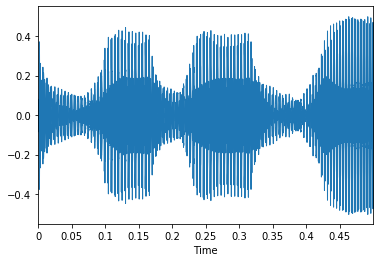

In [25]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=sr, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [26]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [27]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.sr = 44100
        self.input_length = int(sr/2)
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [28]:
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [29]:
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=64, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=64, shuffle=32)

# Model

In [30]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_256_3 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding=True)
        self.conv1d_256_256_3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_256_64 = nn.Linear(in_features=256, out_features=64)
        self.fc_64_1024 = nn.Linear(in_features=64, out_features=1024)
        self.fc_1024_42 = nn.Linear(in_features=1024, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_256_3(x)
        x = self.relu(x)
        x = self.conv1d_256_256_3(x)
        x = self.relu(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_256_64(x)
        x = self.relu(x)
        x = self.fc_64_1024(x)
        x = self.relu(x)
        x = self.fc_1024_42(x)
        x = self.softmax(x)
        
        return x

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 22050))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 22044]             160
              ReLU-2            [-1, 16, 22044]               0
            Conv1d-3            [-1, 16, 22038]           2,320
              ReLU-4            [-1, 16, 22038]               0
         MaxPool1d-5             [-1, 16, 1377]               0
           Dropout-6             [-1, 16, 1377]               0
            Conv1d-7             [-1, 32, 1377]           1,568
              ReLU-8             [-1, 32, 1377]               0
            Conv1d-9             [-1, 32, 1377]           3,104
             ReLU-10             [-1, 32, 1377]               0
        MaxPool1d-11              [-1, 32, 344]               0
          Dropout-12              [-1, 32, 344]               0
           Conv1d-13              [-1, 32, 344]           3,104
             ReLU-14              [-1, 

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Model = FreeSound_Sense()
#Model.float()
#Model.to(device)

Model = FreeSound_Sense()
Model.load_state_dict(torch.load("FreeSound_1D_conv_global_pool_1313_epoch.stDict"))
Model.float()
Model.to(device)

FreeSound_Sense(
  (conv1d_1_16_9): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_16_9): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_32_3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_32_3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_256_3): Conv1d(32, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_256_256_3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (maxpool_16): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigm): Sigmoid()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_256_64): Linear(in_features=256, out_features=64, bias=True)
  (fc_64_1024): Linear(in_features=64, out_features=1024, bias=True)
  (fc_1024_42): Linear(in_features=1024, out_features=

In [35]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [36]:
epoch_progress_bar = tqdm.tqdm(range(0, 1000))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*64)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*64)))


Epoch Loss:  3.377931817239072
Train Acc  39.7452731092437



Valid Acc  40.46875



Epoch Loss:  3.374121092948593
Train Acc  40.27048319327731



Valid Acc  38.854166666666664



Epoch Loss:  3.368508413058369
Train Acc  40.716911764705884



Valid Acc  40.572916666666664



Epoch Loss:  3.373079223793094
Train Acc  40.323004201680675



Valid Acc  40.3125



Epoch Loss:  3.3713140447600547
Train Acc  40.38865546218487



Valid Acc  39.583333333333336



Epoch Loss:  3.36690023967198
Train Acc  40.78256302521008



Valid Acc  39.21875



Epoch Loss:  3.3664281488466665
Train Acc  40.795693277310924



Valid Acc  39.114583333333336



Epoch Loss:  3.367079019546509
Train Acc  40.848214285714285



Valid Acc  39.6875



Epoch Loss:  3.368954434114344
Train Acc  40.65126050420168



Valid Acc  39.895833333333336



Epoch Loss:  3.365666507672863
Train Acc  40.900735294117645



Valid Acc  40.0



Epoch Loss:  3.3706921489298844
Train Acc  40.67752100840336



Valid Acc  38.958333333333336



Epoch Loss:  3.3778486772745597
Train Acc  39.90283613445378



Valid Acc  39.635416666666664



Epoch Loss:  3.3743377393033325
Train Acc  40.38865546218487



Valid Acc  40.260416666666664



Epoch Loss:  3.3683180889161695
Train Acc  40.690651260504204



Valid Acc  40.260416666666664



Epoch Loss:  3.3637124590513086
Train Acc  41.3077731092437



Valid Acc  38.854166666666664



Epoch Loss:  3.369746765168775
Train Acc  40.664390756302524



Valid Acc  40.416666666666664



Epoch Loss:  3.3729481857363917
Train Acc  40.28361344537815



Valid Acc  39.895833333333336



Epoch Loss:  3.3680496215820312
Train Acc  40.743172268907564



Valid Acc  40.0



Epoch Loss:  3.365988875637535
Train Acc  41.09768907563025



Valid Acc  39.84375



Epoch Loss:  3.3723738794567204
Train Acc  40.33613445378151



Valid Acc  38.697916666666664



Epoch Loss:  3.3729197257707098
Train Acc  40.349264705882355



Valid Acc  40.104166666666664



Epoch Loss:  3.3669764134062437
Train Acc  40.848214285714285



Valid Acc  40.416666666666664



Epoch Loss:  3.3653724393924747
Train Acc  40.953256302521005



Valid Acc  39.6875



Epoch Loss:  3.369882481438773
Train Acc  40.57247899159664



Valid Acc  39.53125



Epoch Loss:  3.3744858232866815
Train Acc  40.23109243697479



Valid Acc  39.322916666666664



Epoch Loss:  3.3610181107240567
Train Acc  41.570378151260506



Valid Acc  39.739583333333336



Epoch Loss:  3.370119154954157
Train Acc  40.4936974789916



Valid Acc  39.635416666666664



Epoch Loss:  3.3663359329480085
Train Acc  40.99264705882353



Valid Acc  40.0



Epoch Loss:  3.3672841456757876
Train Acc  40.821953781512605



Valid Acc  39.947916666666664



Epoch Loss:  3.3675631014238885
Train Acc  40.926995798319325



Valid Acc  40.833333333333336



Epoch Loss:  3.3634600078358368
Train Acc  41.3077731092437



Valid Acc  39.6875



Epoch Loss:  3.369935931277876
Train Acc  40.585609243697476



Valid Acc  39.114583333333336



Epoch Loss:  3.368970694662142
Train Acc  40.70378151260504



Valid Acc  40.416666666666664



Epoch Loss:  3.367889077723527
Train Acc  40.795693277310924



Valid Acc  40.572916666666664



Epoch Loss:  3.3644378345553614
Train Acc  41.189600840336134



Valid Acc  39.53125



Epoch Loss:  3.3665228350823666
Train Acc  40.874474789915965



Valid Acc  41.145833333333336



Epoch Loss:  3.3706778738679004
Train Acc  40.51995798319328



Valid Acc  39.583333333333336



Epoch Loss:  3.366912447103933
Train Acc  40.99264705882353



Valid Acc  39.322916666666664



Epoch Loss:  3.3706293586923293
Train Acc  40.51995798319328



Valid Acc  39.947916666666664



Epoch Loss:  3.3685163069172064
Train Acc  40.65126050420168



Valid Acc  39.270833333333336



Epoch Loss:  3.3648346131589233
Train Acc  41.215861344537814



Valid Acc  40.208333333333336



Epoch Loss:  3.3680864842999885
Train Acc  40.821953781512605



Valid Acc  40.208333333333336



Epoch Loss:  3.366171546342994
Train Acc  40.96638655462185



Valid Acc  40.15625



Epoch Loss:  3.367955969161346
Train Acc  40.83508403361345



Valid Acc  40.208333333333336



Epoch Loss:  3.3704404810897444
Train Acc  40.375525210084035



Valid Acc  40.3125



Epoch Loss:  3.3649850693069587
Train Acc  41.07142857142857



Valid Acc  38.229166666666664



Epoch Loss:  3.371300857608058
Train Acc  40.4936974789916



Valid Acc  39.375



Epoch Loss:  3.3679822873668512
Train Acc  40.900735294117645



Valid Acc  39.427083333333336



Epoch Loss:  3.362005920971141
Train Acc  41.36029411764706



Valid Acc  40.625



Epoch Loss:  3.3610565782595083
Train Acc  41.46533613445378



Valid Acc  39.6875



Epoch Loss:  3.3752524432014015
Train Acc  40.034138655462186



Valid Acc  39.166666666666664



Epoch Loss:  3.365973482612802
Train Acc  41.07142857142857



Valid Acc  39.947916666666664



Epoch Loss:  3.368585911117682
Train Acc  40.73004201680672



Valid Acc  39.322916666666664



Epoch Loss:  3.365898687298558
Train Acc  41.03203781512605



Valid Acc  39.791666666666664



Epoch Loss:  3.3660979711708903
Train Acc  40.900735294117645



Valid Acc  40.052083333333336



Epoch Loss:  3.370286741176573
Train Acc  40.51995798319328



Valid Acc  40.520833333333336



Epoch Loss:  3.3624379514646128
Train Acc  41.28151260504202



Valid Acc  41.458333333333336



Epoch Loss:  3.367509096610446
Train Acc  40.97951680672269



Valid Acc  39.895833333333336



Epoch Loss:  3.36222398581625
Train Acc  41.32090336134454



Valid Acc  40.729166666666664



Epoch Loss:  3.3667750358581543
Train Acc  40.821953781512605



Valid Acc  39.791666666666664



Epoch Loss:  3.3657236980790852
Train Acc  40.848214285714285



Valid Acc  39.21875



Epoch Loss:  3.364001003634028
Train Acc  41.16334033613445



Valid Acc  41.041666666666664



Epoch Loss:  3.365778297937217
Train Acc  41.08455882352941



Valid Acc  40.416666666666664



Epoch Loss:  3.3680344810004996
Train Acc  40.874474789915965



Valid Acc  39.791666666666664



Epoch Loss:  3.364080354947002
Train Acc  41.1764705882353



Valid Acc  39.739583333333336



Epoch Loss:  3.3687026019857713
Train Acc  40.559348739495796



Valid Acc  39.947916666666664



Epoch Loss:  3.373009391191627
Train Acc  40.060399159663866



Valid Acc  40.15625



Epoch Loss:  3.364633520110315
Train Acc  41.13707983193277



Valid Acc  39.947916666666664



Epoch Loss:  3.3647875605511066
Train Acc  41.1764705882353



Valid Acc  40.520833333333336



Epoch Loss:  3.3663284718489446
Train Acc  40.91386554621849



Valid Acc  40.885416666666664



Epoch Loss:  3.367913164010569
Train Acc  40.743172268907564



Valid Acc  39.947916666666664



Epoch Loss:  3.3669503195946957
Train Acc  40.91386554621849



Valid Acc  38.854166666666664



Epoch Loss:  3.3708989259575595
Train Acc  40.559348739495796



Valid Acc  38.90625



Epoch Loss:  3.3657981127250096
Train Acc  40.96638655462185



Valid Acc  41.510416666666664



Epoch Loss:  3.3630797281986524
Train Acc  41.215861344537814



Valid Acc  40.364583333333336



Epoch Loss:  3.3655044972395696
Train Acc  41.12394957983193



Valid Acc  40.625



Epoch Loss:  3.364172787225547
Train Acc  41.16334033613445



Valid Acc  40.833333333333336



Epoch Loss:  3.3609362309720336
Train Acc  41.58350840336134



Valid Acc  40.052083333333336



Epoch Loss:  3.367910373110731
Train Acc  40.874474789915965



Valid Acc  40.208333333333336



Epoch Loss:  3.368131369101901
Train Acc  40.795693277310924



Valid Acc  40.260416666666664



Epoch Loss:  3.3691492741849243
Train Acc  40.690651260504204



Valid Acc  40.520833333333336



Epoch Loss:  3.371173846621473
Train Acc  40.401785714285715



Valid Acc  40.625



Epoch Loss:  3.3618572760028997
Train Acc  41.5047268907563



Valid Acc  40.15625



Epoch Loss:  3.3601241772916137
Train Acc  41.58350840336134



Valid Acc  39.479166666666664



Epoch Loss:  3.3610915977413915
Train Acc  41.49159663865546



Valid Acc  40.104166666666664



Epoch Loss:  3.3605561396654915
Train Acc  41.49159663865546



Valid Acc  40.260416666666664



Epoch Loss:  3.3667216761773373
Train Acc  40.900735294117645



Valid Acc  41.197916666666664



Epoch Loss:  3.3647936111738703
Train Acc  41.15021008403362



Valid Acc  40.104166666666664



Epoch Loss:  3.3661256818210377
Train Acc  40.821953781512605



Valid Acc  40.416666666666664



Epoch Loss:  3.369996625836156
Train Acc  40.54621848739496



Valid Acc  41.354166666666664



Epoch Loss:  3.370071743716713
Train Acc  40.54621848739496



Valid Acc  40.260416666666664



Epoch Loss:  3.36897435709208
Train Acc  40.638130252100844



Valid Acc  40.15625



Epoch Loss:  3.3636492641032243
Train Acc  41.28151260504202



Valid Acc  39.947916666666664



Epoch Loss:  3.365931374686105
Train Acc  40.953256302521005



Valid Acc  40.364583333333336



Epoch Loss:  3.3635322005808854
Train Acc  41.20273109243698



Valid Acc  40.885416666666664



Epoch Loss:  3.362193101594428
Train Acc  41.189600840336134



Valid Acc  40.0



Epoch Loss:  3.3677426586631967
Train Acc  40.795693277310924



Valid Acc  41.25



Epoch Loss:  3.3709138221099595
Train Acc  40.690651260504204



Valid Acc  40.052083333333336



Epoch Loss:  3.3565595951400886
Train Acc  41.95115546218487



Valid Acc  40.572916666666664



Epoch Loss:  3.36422256862416
Train Acc  41.11081932773109



Valid Acc  40.520833333333336



Epoch Loss:  3.3632633205221483
Train Acc  41.3734243697479



Valid Acc  40.15625



Epoch Loss:  3.36390684632694
Train Acc  41.09768907563025



Valid Acc  39.427083333333336



Epoch Loss:  3.3677454074891675
Train Acc  40.953256302521005



Valid Acc  40.625



Epoch Loss:  3.3666137647228083
Train Acc  40.97951680672269



Valid Acc  40.208333333333336



Epoch Loss:  3.3729187720963933
Train Acc  40.20483193277311



Valid Acc  40.46875



Epoch Loss:  3.366213223513435
Train Acc  41.08455882352941



Valid Acc  39.479166666666664



Epoch Loss:  3.368125214296229
Train Acc  40.78256302521008



Valid Acc  40.3125



Epoch Loss:  3.3645040087339257
Train Acc  41.03203781512605



Valid Acc  39.479166666666664



Epoch Loss:  3.369801625484178
Train Acc  40.57247899159664



Valid Acc  39.947916666666664



Epoch Loss:  3.3651665779722837
Train Acc  41.04516806722689



Valid Acc  40.364583333333336



Epoch Loss:  3.364466072130604
Train Acc  40.97951680672269



Valid Acc  39.791666666666664



Epoch Loss:  3.3675860657411465
Train Acc  40.769432773109244



Valid Acc  40.572916666666664



Epoch Loss:  3.3652249504538143
Train Acc  41.12394957983193



Valid Acc  41.041666666666664



Epoch Loss:  3.36794710760357
Train Acc  40.848214285714285



Valid Acc  41.145833333333336



Epoch Loss:  3.367090694042815
Train Acc  40.874474789915965



Valid Acc  40.3125



Epoch Loss:  3.3613072663796046
Train Acc  41.53098739495798



Valid Acc  40.416666666666664



Epoch Loss:  3.3646781805182706
Train Acc  41.11081932773109



Valid Acc  39.583333333333336



Epoch Loss:  3.365870964627306
Train Acc  41.01890756302521



Valid Acc  40.46875



Epoch Loss:  3.3647799752339593
Train Acc  40.96638655462185



Valid Acc  40.260416666666664



Epoch Loss:  3.3666526389723064
Train Acc  40.900735294117645



Valid Acc  40.677083333333336



Epoch Loss:  3.369201648135145
Train Acc  40.7563025210084



Valid Acc  40.78125



Epoch Loss:  3.3662087476554037
Train Acc  40.953256302521005



Valid Acc  40.104166666666664



Epoch Loss:  3.3670315782563027
Train Acc  40.91386554621849



Valid Acc  40.9375



Epoch Loss:  3.361141391161109
Train Acc  41.4390756302521



Valid Acc  39.6875



Epoch Loss:  3.365847585581932
Train Acc  40.953256302521005



Valid Acc  39.895833333333336



Epoch Loss:  3.365947733406259
Train Acc  41.04516806722689



Valid Acc  39.895833333333336



Epoch Loss:  3.366015269976704
Train Acc  41.11081932773109



Valid Acc  40.78125



Epoch Loss:  3.3627843696530126
Train Acc  41.33403361344538



Valid Acc  40.46875



Epoch Loss:  3.3687931629789976
Train Acc  40.585609243697476



Valid Acc  40.364583333333336



Epoch Loss:  3.3605945791516985
Train Acc  41.34716386554622



Valid Acc  40.989583333333336



Epoch Loss:  3.368610340006211
Train Acc  40.51995798319328



Valid Acc  40.885416666666664



Epoch Loss:  3.360540770682968
Train Acc  41.47846638655462



Valid Acc  40.625



Epoch Loss:  3.3645887735511075
Train Acc  41.12394957983193



Valid Acc  39.21875



Epoch Loss:  3.3614554845986246
Train Acc  41.3734243697479



Valid Acc  40.572916666666664



Epoch Loss:  3.3631661879916153
Train Acc  41.16334033613445



Valid Acc  41.354166666666664



Epoch Loss:  3.3605892778444693
Train Acc  41.53098739495798



Valid Acc  40.833333333333336



Epoch Loss:  3.359887862405857
Train Acc  41.596638655462186



Valid Acc  40.729166666666664



Epoch Loss:  3.360727111832434
Train Acc  41.3077731092437



Valid Acc  40.625



Epoch Loss:  3.3671066801087197
Train Acc  40.97951680672269



Valid Acc  40.729166666666664



Epoch Loss:  3.36196336425653
Train Acc  41.3734243697479



Valid Acc  40.572916666666664



Epoch Loss:  3.3669607338785124
Train Acc  40.821953781512605



Valid Acc  40.989583333333336



Epoch Loss:  3.364846015176853
Train Acc  40.94012605042017



Valid Acc  39.84375



Epoch Loss:  3.3711861842820623
Train Acc  40.454306722689076



Valid Acc  41.041666666666664



Epoch Loss:  3.3589641727319286
Train Acc  41.6360294117647



Valid Acc  40.833333333333336



Epoch Loss:  3.3653008276674927
Train Acc  41.09768907563025



Valid Acc  40.989583333333336



Epoch Loss:  3.3641188405141107
Train Acc  41.215861344537814



Valid Acc  40.572916666666664



Epoch Loss:  3.3610475443992294
Train Acc  41.46533613445378



Valid Acc  39.84375



Epoch Loss:  3.3655121887431427
Train Acc  41.05829831932773



Valid Acc  40.572916666666664



Epoch Loss:  3.3580554773827562
Train Acc  41.71481092436975



Valid Acc  40.625



Epoch Loss:  3.3632207658110547
Train Acc  41.3077731092437



Valid Acc  40.885416666666664



Epoch Loss:  3.367891413824899
Train Acc  40.7563025210084



Valid Acc  41.09375



Epoch Loss:  3.363563950322255
Train Acc  41.242121848739494



Valid Acc  40.208333333333336



Epoch Loss:  3.3644743666929355
Train Acc  41.3077731092437



Valid Acc  40.46875



Epoch Loss:  3.3659931271016097
Train Acc  40.848214285714285



Valid Acc  40.989583333333336



Epoch Loss:  3.364047948051901
Train Acc  41.215861344537814



Valid Acc  40.625



Epoch Loss:  3.3655635469100056
Train Acc  41.12394957983193



Valid Acc  40.3125



Epoch Loss:  3.3577060258689047
Train Acc  41.72794117647059



Valid Acc  40.885416666666664



Epoch Loss:  3.3643054781841633
Train Acc  41.12394957983193



Valid Acc  40.729166666666664



Epoch Loss:  3.3632931729324724
Train Acc  41.1764705882353



Valid Acc  40.15625



Epoch Loss:  3.364972024404702
Train Acc  41.11081932773109



Valid Acc  39.6875



Epoch Loss:  3.3671647841189087
Train Acc  40.821953781512605



Valid Acc  40.78125



Epoch Loss:  3.358596499226674
Train Acc  41.68855042016807



Valid Acc  40.885416666666664



Epoch Loss:  3.3550553261732854
Train Acc  42.0561974789916



Valid Acc  40.989583333333336



Epoch Loss:  3.3598610112647047
Train Acc  41.64915966386555



Valid Acc  39.270833333333336



Epoch Loss:  3.3669923573982814
Train Acc  40.83508403361345



Valid Acc  40.416666666666664



Epoch Loss:  3.3598502744145753
Train Acc  41.570378151260506



Valid Acc  39.895833333333336



Epoch Loss:  3.363667828696115
Train Acc  41.189600840336134



Valid Acc  40.729166666666664



Epoch Loss:  3.3616228824903986
Train Acc  41.39968487394958



Valid Acc  41.354166666666664



Epoch Loss:  3.3652689396834172
Train Acc  41.12394957983193



Valid Acc  40.729166666666664



Epoch Loss:  3.3623903178367294
Train Acc  41.36029411764706



Valid Acc  40.677083333333336



Epoch Loss:  3.3637422253103817
Train Acc  41.3077731092437



Valid Acc  41.770833333333336



Epoch Loss:  3.361278091158186
Train Acc  41.570378151260506



Valid Acc  41.302083333333336



Epoch Loss:  3.3626571042197093
Train Acc  41.25525210084034



Valid Acc  40.15625



Epoch Loss:  3.358044452026111
Train Acc  41.68855042016807



Valid Acc  40.208333333333336



Epoch Loss:  3.361277574250678
Train Acc  41.34716386554622



Valid Acc  39.895833333333336



Epoch Loss:  3.3602815375608555
Train Acc  41.67542016806723



Valid Acc  41.041666666666664



Epoch Loss:  3.364548024009256
Train Acc  41.09768907563025



Valid Acc  40.46875



Epoch Loss:  3.36706892382197
Train Acc  40.78256302521008



Valid Acc  40.885416666666664



Epoch Loss:  3.359648550257963
Train Acc  41.596638655462186



Valid Acc  41.302083333333336



Epoch Loss:  3.3584208228007086
Train Acc  41.81985294117647



Valid Acc  39.322916666666664



Epoch Loss:  3.3623046354085457
Train Acc  41.38655462184874



Valid Acc  40.989583333333336



Epoch Loss:  3.3618146692003523
Train Acc  41.3734243697479



Valid Acc  41.614583333333336



Epoch Loss:  3.3625205003914713
Train Acc  41.1764705882353



Valid Acc  40.729166666666664



Epoch Loss:  3.3652387807349196
Train Acc  41.05829831932773



Valid Acc  40.572916666666664



Epoch Loss:  3.365186871600752
Train Acc  41.07142857142857



Valid Acc  41.041666666666664



Epoch Loss:  3.3619196254666113
Train Acc  41.39968487394958



Valid Acc  40.260416666666664



Epoch Loss:  3.3599249034368692
Train Acc  41.58350840336134



Valid Acc  40.677083333333336



Epoch Loss:  3.358592167621901
Train Acc  41.58350840336134



Valid Acc  41.458333333333336



Epoch Loss:  3.364527978816954
Train Acc  41.04516806722689



Valid Acc  39.947916666666664



Epoch Loss:  3.3641156989987158
Train Acc  41.16334033613445



Valid Acc  40.46875



Epoch Loss:  3.3635413927190445
Train Acc  41.20273109243698



Valid Acc  39.895833333333336



Epoch Loss:  3.3595650817165854
Train Acc  41.53098739495798



Valid Acc  40.9375



Epoch Loss:  3.3626104402942816
Train Acc  41.38655462184874



Valid Acc  40.0



Epoch Loss:  3.3640112716610693
Train Acc  41.09768907563025



Valid Acc  41.40625



Epoch Loss:  3.36465892671537
Train Acc  40.874474789915965



Valid Acc  41.09375



Epoch Loss:  3.3650354958381974
Train Acc  41.1764705882353



Valid Acc  40.833333333333336



Epoch Loss:  3.3641441649749497
Train Acc  41.1764705882353



Valid Acc  39.375



Epoch Loss:  3.3646440465911094
Train Acc  41.12394957983193



Valid Acc  40.052083333333336



Epoch Loss:  3.363470993122133
Train Acc  41.11081932773109



Valid Acc  41.5625



Epoch Loss:  3.361785514014108
Train Acc  41.42594537815126



Valid Acc  40.989583333333336



Epoch Loss:  3.363649656792649
Train Acc  41.25525210084034



Valid Acc  41.09375



Epoch Loss:  3.361246109008789
Train Acc  41.55724789915966



Valid Acc  40.885416666666664



Epoch Loss:  3.3595106681855786
Train Acc  41.6360294117647



Valid Acc  41.145833333333336



Epoch Loss:  3.362341504137055
Train Acc  41.242121848739494



Valid Acc  39.739583333333336



Epoch Loss:  3.3587112727285433
Train Acc  41.66228991596638



Valid Acc  39.947916666666664



Epoch Loss:  3.367996832903694
Train Acc  40.690651260504204



Valid Acc  40.46875



Epoch Loss:  3.356910288834772
Train Acc  41.79359243697479



Valid Acc  39.270833333333336



Epoch Loss:  3.3642742914312027
Train Acc  41.07142857142857



Valid Acc  41.041666666666664



Epoch Loss:  3.3645775678778898
Train Acc  41.09768907563025



Valid Acc  40.364583333333336



Epoch Loss:  3.363956020659759
Train Acc  41.15021008403362



Valid Acc  40.104166666666664



Epoch Loss:  3.3606949473629477
Train Acc  41.47846638655462



Valid Acc  41.041666666666664



Epoch Loss:  3.3667262582217945
Train Acc  40.86134453781513



Valid Acc  40.15625



Epoch Loss:  3.3625467184211026
Train Acc  41.36029411764706



Valid Acc  39.947916666666664



Epoch Loss:  3.365891460611039
Train Acc  40.88760504201681



Valid Acc  40.520833333333336



Epoch Loss:  3.3633730972514435
Train Acc  41.20273109243698



Valid Acc  40.833333333333336



Epoch Loss:  3.3641626073532747
Train Acc  41.03203781512605



Valid Acc  40.364583333333336



Epoch Loss:  3.364754232037969
Train Acc  41.16334033613445



Valid Acc  40.625



Epoch Loss:  3.360785692679782
Train Acc  41.60976890756302



Valid Acc  39.84375



Epoch Loss:  3.3630200113568987
Train Acc  41.41281512605042



Valid Acc  40.78125



Epoch Loss:  3.361937715225861
Train Acc  41.38655462184874



Valid Acc  39.583333333333336



Epoch Loss:  3.361561939495952
Train Acc  41.45220588235294



Valid Acc  41.145833333333336



Epoch Loss:  3.3604153544962907
Train Acc  41.58350840336134



Valid Acc  40.416666666666664



Epoch Loss:  3.3593709749334
Train Acc  41.64915966386555



Valid Acc  41.458333333333336



Epoch Loss:  3.3601553359953296
Train Acc  41.67542016806723



Valid Acc  40.572916666666664



Epoch Loss:  3.3639808141884684
Train Acc  41.1764705882353



Valid Acc  40.46875



Epoch Loss:  3.3627216675702263
Train Acc  41.38655462184874



Valid Acc  40.885416666666664



Epoch Loss:  3.360173373663125
Train Acc  41.596638655462186



Valid Acc  41.145833333333336



Epoch Loss:  3.3605499147367075
Train Acc  41.41281512605042



Valid Acc  41.145833333333336



Epoch Loss:  3.356316207837658
Train Acc  41.885504201680675



Valid Acc  41.510416666666664



Epoch Loss:  3.3597954361378646
Train Acc  41.60976890756302



Valid Acc  40.520833333333336



Epoch Loss:  3.3606044144189657
Train Acc  41.58350840336134



Valid Acc  40.989583333333336



Epoch Loss:  3.3629587377820696
Train Acc  41.46533613445378



Valid Acc  40.677083333333336



Epoch Loss:  3.362805925497488
Train Acc  41.22899159663866



Valid Acc  40.9375



Epoch Loss:  3.3650124553872756
Train Acc  41.01890756302521



Valid Acc  41.145833333333336



Epoch Loss:  3.3629716684838304
Train Acc  41.242121848739494



Valid Acc  40.989583333333336



Epoch Loss:  3.359152719754131
Train Acc  41.66228991596638



Valid Acc  39.84375



Epoch Loss:  3.370492083685739
Train Acc  40.585609243697476



Valid Acc  40.9375



Epoch Loss:  3.3687812340359726
Train Acc  40.611869747899156



Valid Acc  40.78125



Epoch Loss:  3.3583854567103026
Train Acc  41.68855042016807



Valid Acc  40.989583333333336



Epoch Loss:  3.361673415208063
Train Acc  41.39968487394958



Valid Acc  41.666666666666664



Epoch Loss:  3.3601763088162206
Train Acc  41.58350840336134



Valid Acc  40.833333333333336



Epoch Loss:  3.357280196262007
Train Acc  41.938025210084035



Valid Acc  40.625



Epoch Loss:  3.3582168206447314
Train Acc  41.71481092436975



Valid Acc  40.833333333333336



Epoch Loss:  3.356934503346932
Train Acc  41.859243697478995



Valid Acc  40.15625



Epoch Loss:  3.3644694220118163
Train Acc  41.189600840336134



Valid Acc  40.46875



Epoch Loss:  3.3584858108969295
Train Acc  41.74107142857143



Valid Acc  40.520833333333336



Epoch Loss:  3.3613228457314626
Train Acc  41.46533613445378



Valid Acc  40.572916666666664



Epoch Loss:  3.362365999141661
Train Acc  41.38655462184874



Valid Acc  40.260416666666664



Epoch Loss:  3.36299710313813
Train Acc  41.294642857142854



Valid Acc  40.052083333333336



Epoch Loss:  3.365077205064918
Train Acc  40.96638655462185



Valid Acc  41.145833333333336



Epoch Loss:  3.364293030330113
Train Acc  41.13707983193277



Valid Acc  39.479166666666664



Epoch Loss:  3.3602244813903037
Train Acc  41.64915966386555



Valid Acc  40.416666666666664



Epoch Loss:  3.3589260538085166
Train Acc  41.66228991596638



Valid Acc  41.510416666666664



Epoch Loss:  3.3616689373465145
Train Acc  41.47846638655462



Valid Acc  40.46875



Epoch Loss:  3.3612922420020865
Train Acc  41.47846638655462



Valid Acc  41.458333333333336



Epoch Loss:  3.3606496518399536
Train Acc  41.544117647058826



Valid Acc  41.25



Epoch Loss:  3.362675726914606
Train Acc  41.4390756302521



Valid Acc  41.354166666666664



Epoch Loss:  3.3549862248556956
Train Acc  42.069327731092436



Valid Acc  41.145833333333336



Epoch Loss:  3.3619010969370353
Train Acc  41.33403361344538



Valid Acc  40.989583333333336



Epoch Loss:  3.3614952924872648
Train Acc  41.3734243697479



Valid Acc  41.145833333333336



Epoch Loss:  3.3608823483731567
Train Acc  41.55724789915966



Valid Acc  40.416666666666664



Epoch Loss:  3.3603749435488917
Train Acc  41.6360294117647



Valid Acc  40.729166666666664



Epoch Loss:  3.3592388950476124
Train Acc  41.68855042016807



Valid Acc  40.729166666666664



Epoch Loss:  3.363005910600935
Train Acc  41.32090336134454



Valid Acc  41.041666666666664



Epoch Loss:  3.3620253550906143
Train Acc  41.33403361344538



Valid Acc  41.614583333333336



Epoch Loss:  3.363091256438183
Train Acc  41.38655462184874



Valid Acc  40.677083333333336



Epoch Loss:  3.3600871302500495
Train Acc  41.517857142857146



Valid Acc  41.510416666666664



Epoch Loss:  3.3618948860328737
Train Acc  41.22899159663866



Valid Acc  40.833333333333336



Epoch Loss:  3.3594073507966113
Train Acc  41.75420168067227



Valid Acc  41.145833333333336



Epoch Loss:  3.3529605985689566
Train Acc  42.331932773109244



Valid Acc  39.427083333333336



Epoch Loss:  3.367608461059442
Train Acc  40.78256302521008



Valid Acc  40.15625



Epoch Loss:  3.3619728629328622
Train Acc  41.215861344537814



Valid Acc  40.416666666666664



Epoch Loss:  3.365588019875919
Train Acc  41.09768907563025



Valid Acc  40.833333333333336



Epoch Loss:  3.360346555709839
Train Acc  41.596638655462186



Valid Acc  39.791666666666664



Epoch Loss:  3.363998142611079
Train Acc  41.07142857142857



Valid Acc  40.3125



Epoch Loss:  3.3613438165488363
Train Acc  41.39968487394958



Valid Acc  40.989583333333336



Epoch Loss:  3.3575341901859317
Train Acc  41.938025210084035



Valid Acc  40.625



Epoch Loss:  3.356136159736569
Train Acc  41.938025210084035



Valid Acc  40.364583333333336



Epoch Loss:  3.36017633285843
Train Acc  41.66228991596638



Valid Acc  41.041666666666664



Epoch Loss:  3.35884111869235
Train Acc  41.74107142857143



Valid Acc  41.09375



Epoch Loss:  3.361701947300374
Train Acc  41.36029411764706



Valid Acc  40.208333333333336



Epoch Loss:  3.3584271338807437
Train Acc  41.74107142857143



Valid Acc  38.90625



Epoch Loss:  3.3664897630194655
Train Acc  40.953256302521005



Valid Acc  41.354166666666664



Epoch Loss:  3.3575062771805193
Train Acc  41.83298319327731



Valid Acc  40.208333333333336



Epoch Loss:  3.359234172756932
Train Acc  41.68855042016807



Valid Acc  41.354166666666664



Epoch Loss:  3.3619171931964007
Train Acc  41.36029411764706



Valid Acc  41.041666666666664



Epoch Loss:  3.3600244301707805
Train Acc  41.58350840336134



Valid Acc  40.104166666666664



Epoch Loss:  3.361805288731551
Train Acc  41.39968487394958



Valid Acc  40.052083333333336



Epoch Loss:  3.3566321084479323
Train Acc  41.95115546218487



Valid Acc  40.729166666666664



Epoch Loss:  3.361680171068977
Train Acc  41.544117647058826



Valid Acc  41.09375



Epoch Loss:  3.360020986124247
Train Acc  41.6360294117647



Valid Acc  42.447916666666664



Epoch Loss:  3.359822810197077
Train Acc  41.544117647058826



Valid Acc  41.145833333333336



Epoch Loss:  3.3597666816551146
Train Acc  41.5047268907563



Valid Acc  41.40625



Epoch Loss:  3.363504724342282
Train Acc  41.36029411764706



Valid Acc  40.15625



Epoch Loss:  3.3593609192792107
Train Acc  41.6360294117647



Valid Acc  41.40625



Epoch Loss:  3.358916198506075
Train Acc  41.64915966386555



Valid Acc  41.614583333333336



Epoch Loss:  3.3600376553896094
Train Acc  41.53098739495798



Valid Acc  40.364583333333336



Epoch Loss:  3.3593162067798006
Train Acc  41.72794117647059



Valid Acc  40.520833333333336



Epoch Loss:  3.360741811640122
Train Acc  41.42594537815126



Valid Acc  40.9375



Epoch Loss:  3.350922382178427
Train Acc  42.47636554621849



Valid Acc  40.520833333333336



Epoch Loss:  3.3571656972420314
Train Acc  41.84611344537815



Valid Acc  40.885416666666664



Epoch Loss:  3.357298712770478
Train Acc  41.990546218487395



Valid Acc  40.416666666666664



Epoch Loss:  3.355962164261762
Train Acc  42.02993697478992



Valid Acc  40.78125



Epoch Loss:  3.3607232791035115
Train Acc  41.622899159663866



Valid Acc  41.09375



Epoch Loss:  3.3627881643151034
Train Acc  41.3734243697479



Valid Acc  41.875



Epoch Loss:  3.358256474262526
Train Acc  41.72794117647059



Valid Acc  41.927083333333336



Epoch Loss:  3.364129579367758
Train Acc  41.13707983193277



Valid Acc  41.458333333333336



Epoch Loss:  3.359409949358772
Train Acc  41.74107142857143



Valid Acc  39.947916666666664



Epoch Loss:  3.360364312885188
Train Acc  41.58350840336134



Valid Acc  41.041666666666664



Epoch Loss:  3.3600320876145564
Train Acc  41.58350840336134



Valid Acc  41.927083333333336



Epoch Loss:  3.3607903288192107
Train Acc  41.42594537815126



Valid Acc  41.09375



Epoch Loss:  3.3583722014387116
Train Acc  41.80672268907563



Valid Acc  41.979166666666664



Epoch Loss:  3.359828814738939
Train Acc  41.544117647058826



Valid Acc  40.677083333333336



Epoch Loss:  3.3646942026474895
Train Acc  41.03203781512605



Valid Acc  42.03125



Epoch Loss:  3.361152244215252
Train Acc  41.46533613445378



Valid Acc  39.791666666666664



Epoch Loss:  3.3586102433565284
Train Acc  41.79359243697479



Valid Acc  40.833333333333336



Epoch Loss:  3.3588763846068823
Train Acc  41.80672268907563



Valid Acc  40.416666666666664



Epoch Loss:  3.3586520527591226
Train Acc  41.76733193277311



Valid Acc  39.947916666666664



Epoch Loss:  3.3597516212142815
Train Acc  41.70168067226891



Valid Acc  40.3125



Epoch Loss:  3.360957816869271
Train Acc  41.46533613445378



Valid Acc  40.416666666666664



Epoch Loss:  3.3609724645855046
Train Acc  41.60976890756302



Valid Acc  41.25



Epoch Loss:  3.358790473777707
Train Acc  41.6360294117647



Valid Acc  41.041666666666664



Epoch Loss:  3.359303626693597
Train Acc  41.64915966386555



Valid Acc  41.927083333333336



Epoch Loss:  3.3607923283296475
Train Acc  41.5047268907563



Valid Acc  40.833333333333336



Epoch Loss:  3.3605363669515658
Train Acc  41.6360294117647



Valid Acc  41.302083333333336



Epoch Loss:  3.3542910944513915
Train Acc  42.069327731092436



Valid Acc  40.78125



Epoch Loss:  3.358025785253829
Train Acc  41.76733193277311



Valid Acc  39.21875



Epoch Loss:  3.359613474677591
Train Acc  41.64915966386555



Valid Acc  41.875



Epoch Loss:  3.358544624152304
Train Acc  41.95115546218487



Valid Acc  40.677083333333336



Epoch Loss:  3.356997914674903
Train Acc  41.79359243697479



Valid Acc  41.302083333333336



Epoch Loss:  3.356260251598198
Train Acc  41.89863445378151



Valid Acc  41.197916666666664



Epoch Loss:  3.363550582853686
Train Acc  41.3077731092437



Valid Acc  41.09375



Epoch Loss:  3.3565324875486997
Train Acc  41.990546218487395



Valid Acc  41.614583333333336



Epoch Loss:  3.3578511125901165
Train Acc  41.885504201680675



Valid Acc  41.40625



Epoch Loss:  3.356168622730159
Train Acc  41.885504201680675



Valid Acc  40.729166666666664



Epoch Loss:  3.359702541046784
Train Acc  41.74107142857143



Valid Acc  41.458333333333336



Epoch Loss:  3.3537954482711663
Train Acc  42.016806722689076



Valid Acc  41.979166666666664



Epoch Loss:  3.358613368843784
Train Acc  41.622899159663866



Valid Acc  40.052083333333336



Epoch Loss:  3.3615161190513803
Train Acc  41.58350840336134



Valid Acc  40.208333333333336



Epoch Loss:  3.358169561674615
Train Acc  41.78046218487395



Valid Acc  41.770833333333336



Epoch Loss:  3.358806193375788
Train Acc  41.79359243697479



Valid Acc  40.260416666666664



Epoch Loss:  3.358729017882788
Train Acc  41.64915966386555



Valid Acc  40.572916666666664



Epoch Loss:  3.3601626568481704
Train Acc  41.570378151260506



Valid Acc  40.364583333333336



Epoch Loss:  3.361129963097452
Train Acc  41.45220588235294



Valid Acc  41.145833333333336



Epoch Loss:  3.356831730914717
Train Acc  42.016806722689076



Valid Acc  41.5625



Epoch Loss:  3.359790593636136
Train Acc  41.64915966386555



Valid Acc  41.510416666666664



Epoch Loss:  3.360334214042215
Train Acc  41.60976890756302



Valid Acc  41.25



Epoch Loss:  3.3571324709082853
Train Acc  42.10871848739496



Valid Acc  40.572916666666664



Epoch Loss:  3.3627310981269645
Train Acc  41.32090336134454



Valid Acc  39.791666666666664



Epoch Loss:  3.3622170596563516
Train Acc  41.28151260504202



Valid Acc  41.510416666666664



Epoch Loss:  3.356875648017691
Train Acc  41.92489495798319



Valid Acc  41.40625



Epoch Loss:  3.3609826224190846
Train Acc  41.4390756302521



Valid Acc  40.572916666666664



Epoch Loss:  3.3565544701423966
Train Acc  41.911764705882355



Valid Acc  41.979166666666664



Epoch Loss:  3.3578139693797135
Train Acc  41.78046218487395



Valid Acc  40.885416666666664



Epoch Loss:  3.3658212493447697
Train Acc  40.91386554621849



Valid Acc  40.9375



Epoch Loss:  3.356519941522294
Train Acc  41.92489495798319



Valid Acc  40.833333333333336



Epoch Loss:  3.355576396990223
Train Acc  42.121848739495796



Valid Acc  41.09375



Epoch Loss:  3.36237149879712
Train Acc  41.36029411764706



Valid Acc  40.885416666666664



Epoch Loss:  3.3619137511533848
Train Acc  41.42594537815126



Valid Acc  41.197916666666664



Epoch Loss:  3.3566334307694636
Train Acc  41.859243697478995



Valid Acc  41.145833333333336



Epoch Loss:  3.3571681054700324
Train Acc  41.83298319327731



Valid Acc  40.729166666666664



Epoch Loss:  3.3611259600695442
Train Acc  41.596638655462186



Valid Acc  41.770833333333336



Epoch Loss:  3.35873238379214
Train Acc  41.72794117647059



Valid Acc  40.416666666666664



Epoch Loss:  3.356181924082652
Train Acc  42.00367647058823



Valid Acc  40.833333333333336



Epoch Loss:  3.356705461229597
Train Acc  41.938025210084035



Valid Acc  40.885416666666664



Epoch Loss:  3.3543041373501303
Train Acc  42.121848739495796



Valid Acc  40.989583333333336



Epoch Loss:  3.3575638141952644
Train Acc  41.938025210084035



Valid Acc  41.510416666666664



Epoch Loss:  3.3614872163083374
Train Acc  41.46533613445378



Valid Acc  41.458333333333336



Epoch Loss:  3.3613904424074317
Train Acc  41.36029411764706



Valid Acc  40.833333333333336



Epoch Loss:  3.355571372168405
Train Acc  42.148109243697476



Valid Acc  40.052083333333336



Epoch Loss:  3.364918199907832
Train Acc  41.07142857142857



Valid Acc  40.9375



Epoch Loss:  3.3572882223529974
Train Acc  41.83298319327731



Valid Acc  41.71875



Epoch Loss:  3.35699409797412
Train Acc  41.84611344537815



Valid Acc  40.104166666666664



Epoch Loss:  3.3572884727926815
Train Acc  41.76733193277311



Valid Acc  41.041666666666664



Epoch Loss:  3.3645668109925855
Train Acc  41.15021008403362



Valid Acc  41.145833333333336



Epoch Loss:  3.356680599581294
Train Acc  41.89863445378151



Valid Acc  39.947916666666664



Epoch Loss:  3.355014963310306
Train Acc  41.97741596638655



Valid Acc  41.041666666666664



Epoch Loss:  3.3569066744892537
Train Acc  41.75420168067227



Valid Acc  40.885416666666664



Epoch Loss:  3.354353560119116
Train Acc  42.174369747899156



Valid Acc  41.40625



Epoch Loss:  3.359392933484887
Train Acc  41.70168067226891



Valid Acc  40.729166666666664



Epoch Loss:  3.359194288734628
Train Acc  41.570378151260506



Valid Acc  41.927083333333336



Epoch Loss:  3.3591002776843157
Train Acc  41.76733193277311



Valid Acc  42.239583333333336



Epoch Loss:  3.35204410152275
Train Acc  42.34506302521008



Valid Acc  40.885416666666664



Epoch Loss:  3.357350730094589
Train Acc  41.80672268907563



Valid Acc  40.9375



Epoch Loss:  3.359306209227618
Train Acc  41.622899159663866



Valid Acc  41.041666666666664



Epoch Loss:  3.358437293717841
Train Acc  41.570378151260506



Valid Acc  41.40625



Epoch Loss:  3.3589090018713175
Train Acc  41.78046218487395



Valid Acc  41.302083333333336



Epoch Loss:  3.357749999070368
Train Acc  41.72794117647059



Valid Acc  40.677083333333336



Epoch Loss:  3.353235735612757
Train Acc  42.384453781512605



Valid Acc  40.729166666666664



Epoch Loss:  3.357032647653788
Train Acc  41.964285714285715



Valid Acc  41.40625



Epoch Loss:  3.3584593203889224
Train Acc  41.83298319327731



Valid Acc  41.614583333333336



Epoch Loss:  3.3571967317276643
Train Acc  41.84611344537815



Valid Acc  40.15625



Epoch Loss:  3.356176480525682
Train Acc  41.95115546218487



Valid Acc  41.041666666666664



Epoch Loss:  3.359590085614629
Train Acc  41.75420168067227



Valid Acc  41.40625



Epoch Loss:  3.3612655711775066
Train Acc  41.55724789915966



Valid Acc  40.729166666666664



Epoch Loss:  3.3559147690524576
Train Acc  41.87237394957983



Valid Acc  41.40625



Epoch Loss:  3.355307114224474
Train Acc  42.13497899159664



Valid Acc  40.104166666666664



Epoch Loss:  3.361980935104755
Train Acc  41.36029411764706



Valid Acc  41.302083333333336



Epoch Loss:  3.36277369891896
Train Acc  41.39968487394958



Valid Acc  40.572916666666664



Epoch Loss:  3.3593835730512605
Train Acc  41.70168067226891



Valid Acc  41.875



Epoch Loss:  3.3561582384991047
Train Acc  42.121848739495796



Valid Acc  41.25



Epoch Loss:  3.3563315668025937
Train Acc  41.990546218487395



Valid Acc  40.989583333333336



Epoch Loss:  3.3572149216627873
Train Acc  41.911764705882355



Valid Acc  41.145833333333336



Epoch Loss:  3.3501786003593637
Train Acc  42.59453781512605



Valid Acc  40.520833333333336



Epoch Loss:  3.360205986920525
Train Acc  41.71481092436975



Valid Acc  40.729166666666664



Epoch Loss:  3.3586567269653833
Train Acc  41.71481092436975



Valid Acc  40.78125



Epoch Loss:  3.3614789257530404
Train Acc  41.38655462184874



Valid Acc  40.989583333333336



Epoch Loss:  3.353966741000905
Train Acc  42.29254201680672



Valid Acc  40.677083333333336



Epoch Loss:  3.3563735725499
Train Acc  41.92489495798319



Valid Acc  40.833333333333336



Epoch Loss:  3.3591411033598315
Train Acc  41.64915966386555



Valid Acc  40.677083333333336



Epoch Loss:  3.3566891325622046
Train Acc  42.00367647058823



Valid Acc  40.3125



Epoch Loss:  3.363641694814217
Train Acc  41.242121848739494



Valid Acc  40.520833333333336



Epoch Loss:  3.3537456628655185
Train Acc  42.305672268907564



Valid Acc  41.197916666666664



Epoch Loss:  3.3532737383321556
Train Acc  42.200630252100844



Valid Acc  41.354166666666664



Epoch Loss:  3.3583362523247215
Train Acc  41.74107142857143



Valid Acc  40.416666666666664



Epoch Loss:  3.3587816402691755
Train Acc  41.71481092436975



Valid Acc  41.041666666666664



Epoch Loss:  3.3576695237840926
Train Acc  41.81985294117647



Valid Acc  40.9375



Epoch Loss:  3.3558050824814485
Train Acc  41.938025210084035



Valid Acc  40.208333333333336



Epoch Loss:  3.3538838815288385
Train Acc  42.253151260504204



Valid Acc  40.46875



Epoch Loss:  3.3543085490956024
Train Acc  42.148109243697476



Valid Acc  41.40625



Epoch Loss:  3.3572040906473366
Train Acc  41.81985294117647



Valid Acc  41.302083333333336



Epoch Loss:  3.3546026073584034
Train Acc  42.08245798319328



Valid Acc  41.302083333333336



Epoch Loss:  3.356695199213108
Train Acc  41.92489495798319



Valid Acc  41.197916666666664



Epoch Loss:  3.3573469875239526
Train Acc  41.81985294117647



Valid Acc  40.885416666666664



Epoch Loss:  3.3562198045874845
Train Acc  42.02993697478992



Valid Acc  41.927083333333336



Epoch Loss:  3.3572257166149235
Train Acc  41.84611344537815



Valid Acc  42.395833333333336



Epoch Loss:  3.359121611138352
Train Acc  41.83298319327731



Valid Acc  41.09375



Epoch Loss:  3.356690064197829
Train Acc  41.911764705882355



Valid Acc  42.239583333333336



Epoch Loss:  3.357383559731876
Train Acc  41.81985294117647



Valid Acc  41.510416666666664



Epoch Loss:  3.3585140845354866
Train Acc  41.66228991596638



Valid Acc  40.885416666666664



Epoch Loss:  3.3518723439769587
Train Acc  42.39758403361345



Valid Acc  40.989583333333336



Epoch Loss:  3.3579406678175725
Train Acc  41.964285714285715



Valid Acc  41.197916666666664



Epoch Loss:  3.357486131812344
Train Acc  41.885504201680675



Valid Acc  41.40625



Epoch Loss:  3.3537592266788003
Train Acc  42.174369747899156



Valid Acc  41.979166666666664



Epoch Loss:  3.359591728498956
Train Acc  41.60976890756302



Valid Acc  40.9375



Epoch Loss:  3.3542696167440975
Train Acc  42.226890756302524



Valid Acc  41.614583333333336



Epoch Loss:  3.3532536931398536
Train Acc  42.253151260504204



Valid Acc  41.145833333333336



Epoch Loss:  3.35791154268409
Train Acc  41.859243697478995



Valid Acc  41.40625



Epoch Loss:  3.357453390329826
Train Acc  41.83298319327731



Valid Acc  40.260416666666664



Epoch Loss:  3.3543652867068765
Train Acc  42.016806722689076



Valid Acc  39.895833333333336



Epoch Loss:  3.356457938667105
Train Acc  41.95115546218487



Valid Acc  41.145833333333336



Epoch Loss:  3.3546125047347126
Train Acc  42.0561974789916



Valid Acc  41.40625



Epoch Loss:  3.357080335376643
Train Acc  41.72794117647059



Valid Acc  40.78125



Epoch Loss:  3.3588623860303093
Train Acc  41.76733193277311



Valid Acc  41.25



Epoch Loss:  3.35388393562381
Train Acc  42.279411764705884



Valid Acc  40.15625



Epoch Loss:  3.355259500631765
Train Acc  42.0561974789916



Valid Acc  41.770833333333336



Epoch Loss:  3.357532429094074
Train Acc  41.64915966386555



Valid Acc  40.833333333333336



Epoch Loss:  3.3538269195236077
Train Acc  42.24002100840336



Valid Acc  40.729166666666664



Epoch Loss:  3.356039906750206
Train Acc  41.97741596638655



Valid Acc  40.677083333333336



Epoch Loss:  3.3511625718669733
Train Acc  42.39758403361345



Valid Acc  41.458333333333336



Epoch Loss:  3.353955523306582
Train Acc  42.226890756302524



Valid Acc  40.572916666666664



Epoch Loss:  3.3505508739407324
Train Acc  42.45010504201681



Valid Acc  41.354166666666664



Epoch Loss:  3.3565431703038575
Train Acc  41.859243697478995



Valid Acc  41.041666666666664



Epoch Loss:  3.353301717453644
Train Acc  42.3188025210084



Valid Acc  41.09375



Epoch Loss:  3.35644212690722
Train Acc  41.95115546218487



Valid Acc  40.15625



Epoch Loss:  3.356347687104169
Train Acc  41.938025210084035



Valid Acc  40.625



Epoch Loss:  3.3566837911846257
Train Acc  41.76733193277311



Valid Acc  41.614583333333336



Epoch Loss:  3.355027152710602
Train Acc  42.016806722689076



Valid Acc  41.197916666666664



Epoch Loss:  3.3600839686994792
Train Acc  41.570378151260506



Valid Acc  40.052083333333336



Epoch Loss:  3.348840114449253
Train Acc  42.60766806722689



Valid Acc  41.09375



Epoch Loss:  3.3580827532696125
Train Acc  41.76733193277311



Valid Acc  41.510416666666664



Epoch Loss:  3.3546791657680224
Train Acc  42.08245798319328



Valid Acc  40.677083333333336



Epoch Loss:  3.354279247652583
Train Acc  42.095588235294116



Valid Acc  41.875



Epoch Loss:  3.3567273716966644
Train Acc  41.964285714285715



Valid Acc  41.666666666666664



Epoch Loss:  3.354052261144173
Train Acc  42.21376050420168



Valid Acc  41.510416666666664



Epoch Loss:  3.350586039679391
Train Acc  42.50262605042017



Valid Acc  40.729166666666664



Epoch Loss:  3.3551567562487947
Train Acc  42.095588235294116



Valid Acc  41.197916666666664



Epoch Loss:  3.3547471290876887
Train Acc  42.08245798319328



Valid Acc  40.9375



Epoch Loss:  3.3497922180079613
Train Acc  42.71271008403362



Valid Acc  42.135416666666664



Epoch Loss:  3.351865974794917
Train Acc  42.1875



Valid Acc  41.25



Epoch Loss:  3.3599055554686474
Train Acc  41.55724789915966



Valid Acc  41.510416666666664



Epoch Loss:  3.360497057938776
Train Acc  41.49159663865546



Valid Acc  41.822916666666664



Epoch Loss:  3.3623184436509588
Train Acc  41.38655462184874



Valid Acc  41.614583333333336



Epoch Loss:  3.3543181479478084
Train Acc  42.34506302521008



Valid Acc  41.302083333333336



Epoch Loss:  3.3552440114381934
Train Acc  42.121848739495796



Valid Acc  40.572916666666664



Epoch Loss:  3.3561802010576263
Train Acc  41.97741596638655



Valid Acc  41.09375



Epoch Loss:  3.3608680212197184
Train Acc  41.570378151260506



Valid Acc  41.666666666666664



Epoch Loss:  3.3522349906568767
Train Acc  42.279411764705884



Valid Acc  41.197916666666664



Epoch Loss:  3.354522322406288
Train Acc  42.08245798319328



Valid Acc  41.875



Epoch Loss:  3.356344449419935
Train Acc  41.87237394957983



Valid Acc  41.197916666666664



Epoch Loss:  3.35119875338899
Train Acc  42.436974789915965



Valid Acc  40.78125



Epoch Loss:  3.3509606794148934
Train Acc  42.55514705882353



Valid Acc  40.625



Epoch Loss:  3.3560630814367984
Train Acc  41.964285714285715



Valid Acc  41.927083333333336



Epoch Loss:  3.352986311712185
Train Acc  42.29254201680672



Valid Acc  41.979166666666664



Epoch Loss:  3.3548837629686883
Train Acc  42.02993697478992



Valid Acc  42.135416666666664



Epoch Loss:  3.3524808422857975
Train Acc  42.24002100840336



Valid Acc  41.666666666666664



Epoch Loss:  3.353277663222882
Train Acc  42.21376050420168



Valid Acc  40.677083333333336



Epoch Loss:  3.3567855418229304
Train Acc  41.80672268907563



Valid Acc  40.78125



Epoch Loss:  3.3555213904180445
Train Acc  42.095588235294116



Valid Acc  41.041666666666664



Epoch Loss:  3.3535973584952474
Train Acc  42.200630252100844



Valid Acc  41.145833333333336



Epoch Loss:  3.358556939774201
Train Acc  41.544117647058826



Valid Acc  41.822916666666664



Epoch Loss:  3.3559899650701954
Train Acc  42.0561974789916



Valid Acc  41.71875



Epoch Loss:  3.3509482796452628
Train Acc  42.63392857142857



Valid Acc  42.864583333333336



Epoch Loss:  3.3504677079304925
Train Acc  42.47636554621849



Valid Acc  41.458333333333336



Epoch Loss:  3.353976818693786
Train Acc  42.121848739495796



Valid Acc  41.09375



Epoch Loss:  3.351144670438366
Train Acc  42.47636554621849



Valid Acc  41.822916666666664



Epoch Loss:  3.356660211787504
Train Acc  42.00367647058823



Valid Acc  42.1875



Epoch Loss:  3.355957654343934
Train Acc  42.121848739495796



Valid Acc  41.666666666666664



Epoch Loss:  3.351458194876919
Train Acc  42.42384453781513



Valid Acc  41.354166666666664



Epoch Loss:  3.3573862945332245
Train Acc  41.79359243697479



Valid Acc  41.25



Epoch Loss:  3.356203051174388
Train Acc  41.938025210084035



Valid Acc  42.34375



Epoch Loss:  3.3501455282964625
Train Acc  42.52888655462185



Valid Acc  40.0



Epoch Loss:  3.354384380228379
Train Acc  42.121848739495796



Valid Acc  41.302083333333336



Epoch Loss:  3.3602378588764608
Train Acc  41.570378151260506



Valid Acc  42.447916666666664



Epoch Loss:  3.3571824967360295
Train Acc  41.74107142857143



Valid Acc  42.083333333333336



Epoch Loss:  3.3524926149544596
Train Acc  42.436974789915965



Valid Acc  40.729166666666664



Epoch Loss:  3.35517499226482
Train Acc  42.13497899159664



Valid Acc  42.395833333333336



Epoch Loss:  3.3548514782881536
Train Acc  42.121848739495796



Valid Acc  41.302083333333336



Epoch Loss:  3.356365302029778
Train Acc  41.911764705882355



Valid Acc  41.5625



Epoch Loss:  3.349716763536469
Train Acc  42.68644957983193



Valid Acc  41.770833333333336



Epoch Loss:  3.3493086430205015
Train Acc  42.489495798319325



Valid Acc  42.083333333333336



Epoch Loss:  3.3612562888810613
Train Acc  41.570378151260506



Valid Acc  41.666666666666664



Epoch Loss:  3.3582280403425715
Train Acc  41.80672268907563



Valid Acc  42.34375



Epoch Loss:  3.3558350871591007
Train Acc  41.885504201680675



Valid Acc  40.677083333333336



Epoch Loss:  3.3575851797055796
Train Acc  41.83298319327731



Valid Acc  41.979166666666664



Epoch Loss:  3.35678679402135
Train Acc  41.92489495798319



Valid Acc  40.46875



Epoch Loss:  3.359189658605752
Train Acc  41.68855042016807



Valid Acc  41.40625



Epoch Loss:  3.351418280801853
Train Acc  42.39758403361345



Valid Acc  41.09375



Epoch Loss:  3.351771176362238
Train Acc  42.410714285714285



Valid Acc  41.875



Epoch Loss:  3.3562798419920337
Train Acc  41.95115546218487



Valid Acc  41.666666666666664



Epoch Loss:  3.3575643471309116
Train Acc  41.84611344537815



Valid Acc  42.291666666666664



Epoch Loss:  3.3530767204380836
Train Acc  42.331932773109244



Valid Acc  41.875



Epoch Loss:  3.3510153193433747
Train Acc  42.489495798319325



Valid Acc  42.65625



Epoch Loss:  3.350753505690759
Train Acc  42.50262605042017



Valid Acc  42.03125



Epoch Loss:  3.3561668576312664
Train Acc  41.92489495798319



Valid Acc  40.729166666666664



Epoch Loss:  3.3581371968533813
Train Acc  41.79359243697479



Valid Acc  41.979166666666664



Epoch Loss:  3.3589511899387134
Train Acc  41.75420168067227



Valid Acc  41.614583333333336



Epoch Loss:  3.3560373402443253
Train Acc  41.89863445378151



Valid Acc  41.614583333333336



Epoch Loss:  3.356258091806364
Train Acc  42.08245798319328



Valid Acc  40.729166666666664



Epoch Loss:  3.354348272836509
Train Acc  42.069327731092436



Valid Acc  40.677083333333336



Epoch Loss:  3.356123906223714
Train Acc  41.89863445378151



Valid Acc  40.989583333333336



Epoch Loss:  3.361626781335398
Train Acc  41.53098739495798



Valid Acc  42.083333333333336



Epoch Loss:  3.3569548290316797
Train Acc  41.938025210084035



Valid Acc  41.25



Epoch Loss:  3.3529367066231095
Train Acc  42.34506302521008



Valid Acc  41.40625



Epoch Loss:  3.351598725599401
Train Acc  42.37132352941177



Valid Acc  40.833333333333336



Epoch Loss:  3.358037199292864
Train Acc  41.83298319327731



Valid Acc  41.302083333333336



Epoch Loss:  3.3545560095490528
Train Acc  42.279411764705884



Valid Acc  42.447916666666664



Epoch Loss:  3.3544972664167902
Train Acc  41.97741596638655



Valid Acc  40.9375



Epoch Loss:  3.3522203449441603
Train Acc  42.358193277310924



Valid Acc  41.354166666666664



Epoch Loss:  3.3521093801290047
Train Acc  42.45010504201681



Valid Acc  40.989583333333336



Epoch Loss:  3.355958840426277
Train Acc  41.89863445378151



Valid Acc  42.604166666666664



Epoch Loss:  3.3527375950532803
Train Acc  42.3188025210084



Valid Acc  41.302083333333336



Epoch Loss:  3.351084627023264
Train Acc  42.489495798319325



Valid Acc  40.78125



Epoch Loss:  3.3532220616060147
Train Acc  42.279411764705884



Valid Acc  41.875



Epoch Loss:  3.354171666778436
Train Acc  42.095588235294116



Valid Acc  41.458333333333336



Epoch Loss:  3.35621292250497
Train Acc  41.97741596638655



Valid Acc  41.666666666666664



Epoch Loss:  3.352000272574545
Train Acc  42.50262605042017



Valid Acc  40.3125



Epoch Loss:  3.357024323038694
Train Acc  41.76733193277311



Valid Acc  42.447916666666664



Epoch Loss:  3.357441709822967
Train Acc  41.84611344537815



Valid Acc  41.041666666666664



Epoch Loss:  3.3542342546607267
Train Acc  42.1875



Valid Acc  42.760416666666664



Epoch Loss:  3.3571893547763345
Train Acc  41.95115546218487



Valid Acc  40.78125



Epoch Loss:  3.3546333914043522
Train Acc  42.148109243697476



Valid Acc  42.239583333333336



Epoch Loss:  3.3565935808069565
Train Acc  41.79359243697479



Valid Acc  42.135416666666664



Epoch Loss:  3.354974846879975
Train Acc  42.174369747899156



Valid Acc  42.03125



Epoch Loss:  3.3524460031204866
Train Acc  42.24002100840336



Valid Acc  41.666666666666664



Epoch Loss:  3.3559841909328427
Train Acc  41.95115546218487



Valid Acc  41.458333333333336



Epoch Loss:  3.350623100745578
Train Acc  42.489495798319325



Valid Acc  41.5625



Epoch Loss:  3.354185971893182
Train Acc  42.10871848739496



Valid Acc  40.833333333333336



Epoch Loss:  3.35965966176586
Train Acc  41.596638655462186



Valid Acc  42.1875



Epoch Loss:  3.355072594490372
Train Acc  42.148109243697476



Valid Acc  42.239583333333336



Epoch Loss:  3.3529275104779157
Train Acc  42.45010504201681



Valid Acc  41.354166666666664



Epoch Loss:  3.358728651239091
Train Acc  41.71481092436975



Valid Acc  41.25



Epoch Loss:  3.3534612295006503
Train Acc  42.16123949579832



Valid Acc  42.291666666666664



Epoch Loss:  3.3522519083584057
Train Acc  42.47636554621849



Valid Acc  40.572916666666664



Epoch Loss:  3.355662281773671
Train Acc  42.095588235294116



Valid Acc  41.822916666666664



Epoch Loss:  3.3547158080990576
Train Acc  42.148109243697476



Valid Acc  40.78125



Epoch Loss:  3.353064881653345
Train Acc  42.42384453781513



Valid Acc  42.5



Epoch Loss:  3.3531746804213323
Train Acc  42.410714285714285



Valid Acc  41.197916666666664



Epoch Loss:  3.3542786566149285
Train Acc  42.21376050420168



Valid Acc  41.302083333333336



Epoch Loss:  3.3568584097533667
Train Acc  41.89863445378151



Valid Acc  40.3125



Epoch Loss:  3.3579774584089006
Train Acc  41.76733193277311



Valid Acc  42.34375



Epoch Loss:  3.3553948522615835
Train Acc  42.10871848739496



Valid Acc  41.875



Epoch Loss:  3.3574074356495833
Train Acc  41.885504201680675



Valid Acc  41.979166666666664



Epoch Loss:  3.352835444843068
Train Acc  42.3188025210084



Valid Acc  41.510416666666664



Epoch Loss:  3.3518809931618825
Train Acc  42.253151260504204



Valid Acc  40.260416666666664



Epoch Loss:  3.35118402352854
Train Acc  42.60766806722689



Valid Acc  41.145833333333336



Epoch Loss:  3.3523348319430313
Train Acc  42.226890756302524



Valid Acc  40.729166666666664



Epoch Loss:  3.3492394194883457
Train Acc  42.68644957983193



Valid Acc  40.416666666666664



Epoch Loss:  3.3540265119376302
Train Acc  42.21376050420168



Valid Acc  41.302083333333336



Epoch Loss:  3.3498063167604077
Train Acc  42.50262605042017



Valid Acc  40.729166666666664



Epoch Loss:  3.3542893533947087
Train Acc  42.21376050420168



Valid Acc  42.291666666666664



Epoch Loss:  3.3536352069438005
Train Acc  42.16123949579832



Valid Acc  40.572916666666664



Epoch Loss:  3.3515653109350123
Train Acc  42.489495798319325



Valid Acc  42.5



Epoch Loss:  3.348513493016988
Train Acc  42.9359243697479



Valid Acc  42.65625



Epoch Loss:  3.3533069225920347
Train Acc  42.3188025210084



Valid Acc  41.875



Epoch Loss:  3.353827931299931
Train Acc  42.29254201680672



Valid Acc  42.395833333333336



Epoch Loss:  3.352832696017097
Train Acc  42.305672268907564



Valid Acc  40.833333333333336



Epoch Loss:  3.3525995987803996
Train Acc  42.253151260504204



Valid Acc  41.145833333333336



Epoch Loss:  3.352270597169379
Train Acc  42.384453781512605



Valid Acc  40.572916666666664



Epoch Loss:  3.349733412766657
Train Acc  42.52888655462185



Valid Acc  42.03125



Epoch Loss:  3.352509276205752
Train Acc  42.384453781512605



Valid Acc  41.041666666666664



Epoch Loss:  3.3485829048797866
Train Acc  42.778361344537814



Valid Acc  41.197916666666664



Epoch Loss:  3.3527958733694896
Train Acc  42.226890756302524



Valid Acc  41.822916666666664



Epoch Loss:  3.355207385135298
Train Acc  42.0561974789916



Valid Acc  41.979166666666664



Epoch Loss:  3.3563802763193595
Train Acc  41.92489495798319



Valid Acc  40.46875



Epoch Loss:  3.354306379286181
Train Acc  42.226890756302524



Valid Acc  41.25



Epoch Loss:  3.355886102724476
Train Acc  42.121848739495796



Valid Acc  41.197916666666664



Epoch Loss:  3.348321840542705
Train Acc  42.81775210084034



Valid Acc  41.875



Epoch Loss:  3.355120442494625
Train Acc  42.121848739495796



Valid Acc  40.885416666666664



Epoch Loss:  3.3555269822353075
Train Acc  42.16123949579832



Valid Acc  41.041666666666664



Epoch Loss:  3.3513409730767
Train Acc  42.358193277310924



Valid Acc  41.354166666666664



Epoch Loss:  3.3487446468417383
Train Acc  42.830882352941174



Valid Acc  41.770833333333336



Epoch Loss:  3.3562178050770477
Train Acc  41.911764705882355



Valid Acc  41.041666666666664



Epoch Loss:  3.353456621410466
Train Acc  42.26628151260504



Valid Acc  42.447916666666664



Epoch Loss:  3.3539863995143344
Train Acc  42.253151260504204



Valid Acc  40.572916666666664



Epoch Loss:  3.353175928612717
Train Acc  42.1875



Valid Acc  41.71875



Epoch Loss:  3.354416540690831
Train Acc  42.226890756302524



Valid Acc  42.34375



Epoch Loss:  3.352380371895157
Train Acc  42.3188025210084



Valid Acc  41.25



Epoch Loss:  3.352718495521225
Train Acc  42.358193277310924



Valid Acc  41.5625



Epoch Loss:  3.3476942126490488
Train Acc  42.8702731092437



Valid Acc  41.40625



Epoch Loss:  3.350812096555694
Train Acc  42.436974789915965



Valid Acc  40.729166666666664



Epoch Loss:  3.353711759342867
Train Acc  42.121848739495796



Valid Acc  42.447916666666664



Epoch Loss:  3.355646177500236
Train Acc  42.10871848739496



Valid Acc  42.552083333333336



Epoch Loss:  3.3517505621709742
Train Acc  42.463235294117645



Valid Acc  42.34375



Epoch Loss:  3.3570962813721987
Train Acc  41.92489495798319



Valid Acc  42.395833333333336



Epoch Loss:  3.349215235028948
Train Acc  42.76523109243698



Valid Acc  40.989583333333336



Epoch Loss:  3.3531788116743586
Train Acc  42.384453781512605



Valid Acc  42.395833333333336



Epoch Loss:  3.3535343057969036
Train Acc  42.34506302521008



Valid Acc  41.40625



Epoch Loss:  3.35860486992267
Train Acc  41.87237394957983



Valid Acc  42.395833333333336



Epoch Loss:  3.353312099681181
Train Acc  42.279411764705884



Valid Acc  41.302083333333336



Epoch Loss:  3.3537155920717896
Train Acc  42.200630252100844



Valid Acc  40.729166666666664



Epoch Loss:  3.353740505811547
Train Acc  42.13497899159664



Valid Acc  41.145833333333336



Epoch Loss:  3.351898227419172
Train Acc  42.26628151260504



Valid Acc  41.354166666666664



Epoch Loss:  3.3534518891021987
Train Acc  42.226890756302524



Valid Acc  40.833333333333336



Epoch Loss:  3.3514647884529176
Train Acc  42.39758403361345



Valid Acc  41.71875



Epoch Loss:  3.358123613004925
Train Acc  41.859243697478995



Valid Acc  40.833333333333336



Epoch Loss:  3.3529649682405616
Train Acc  42.121848739495796



Valid Acc  41.822916666666664



Epoch Loss:  3.3532812334910163
Train Acc  42.226890756302524



Valid Acc  42.135416666666664



Epoch Loss:  3.3537601062229703
Train Acc  42.043067226890756



Valid Acc  41.979166666666664



Epoch Loss:  3.35538668592437
Train Acc  41.964285714285715



Valid Acc  41.145833333333336



Epoch Loss:  3.3516149140205704
Train Acc  42.34506302521008



Valid Acc  43.28125



Epoch Loss:  3.353355463813333
Train Acc  42.174369747899156



Valid Acc  41.614583333333336



Epoch Loss:  3.3560731210628476
Train Acc  41.87237394957983



Valid Acc  42.135416666666664



Epoch Loss:  3.3497201434704436
Train Acc  42.63392857142857



Valid Acc  41.614583333333336



Epoch Loss:  3.3498474670057536
Train Acc  42.59453781512605



Valid Acc  41.927083333333336



Epoch Loss:  3.355135282548536
Train Acc  42.095588235294116



Valid Acc  42.239583333333336



Epoch Loss:  3.355093401019313
Train Acc  42.121848739495796



Valid Acc  41.927083333333336



Epoch Loss:  3.349414595034944
Train Acc  42.7389705882353



Valid Acc  42.03125



Epoch Loss:  3.3565451457720843
Train Acc  41.89863445378151



Valid Acc  41.354166666666664



Epoch Loss:  3.347704841309235
Train Acc  42.97531512605042



Valid Acc  41.927083333333336



Epoch Loss:  3.3479176348998765
Train Acc  42.84401260504202



Valid Acc  41.40625



Epoch Loss:  3.3556406037146305
Train Acc  42.10871848739496



Valid Acc  41.614583333333336



Epoch Loss:  3.346838874977176
Train Acc  42.804621848739494



Valid Acc  42.552083333333336



Epoch Loss:  3.3529085331604263
Train Acc  42.42384453781513



Valid Acc  42.447916666666664



Epoch Loss:  3.353016059939601
Train Acc  42.200630252100844



Valid Acc  42.239583333333336



Epoch Loss:  3.354974798795556
Train Acc  42.148109243697476



Valid Acc  41.875



Epoch Loss:  3.352916697494122
Train Acc  42.331932773109244



Valid Acc  40.78125



Epoch Loss:  3.3514146063508106
Train Acc  42.358193277310924



Valid Acc  41.25



Epoch Loss:  3.3509045108025814
Train Acc  42.45010504201681



Valid Acc  42.1875



Epoch Loss:  3.3504587902742275
Train Acc  42.45010504201681



Valid Acc  42.291666666666664



Epoch Loss:  3.35573921283754
Train Acc  42.043067226890756



Valid Acc  41.666666666666664



Epoch Loss:  3.3499090030413714
Train Acc  42.7389705882353



Valid Acc  42.291666666666664



Epoch Loss:  3.354080069966677
Train Acc  42.1875



Valid Acc  42.5



Epoch Loss:  3.3541416500796792
Train Acc  42.148109243697476



Valid Acc  42.65625



Epoch Loss:  3.3482818603515625
Train Acc  42.857142857142854



Valid Acc  41.822916666666664



Epoch Loss:  3.3493775520004143
Train Acc  42.56827731092437



Valid Acc  42.395833333333336



Epoch Loss:  3.3520262181258
Train Acc  42.515756302521005



Valid Acc  42.239583333333336



Epoch Loss:  3.352464503600818
Train Acc  42.358193277310924



Valid Acc  41.875



Epoch Loss:  3.354181946826582
Train Acc  42.1875



Valid Acc  40.989583333333336



Epoch Loss:  3.352707251781175
Train Acc  42.279411764705884



Valid Acc  41.145833333333336



Epoch Loss:  3.3520206263085375
Train Acc  42.489495798319325



Valid Acc  41.822916666666664



Epoch Loss:  3.350043356919489
Train Acc  42.515756302521005



Valid Acc  40.729166666666664



Epoch Loss:  3.351153626161463
Train Acc  42.52888655462185



Valid Acc  42.083333333333336



Epoch Loss:  3.351560145866971
Train Acc  42.42384453781513



Valid Acc  40.885416666666664



Epoch Loss:  3.3501136843897714
Train Acc  42.463235294117645



Valid Acc  42.96875



Epoch Loss:  3.3494244823936654
Train Acc  42.8702731092437



Valid Acc  41.458333333333336



Epoch Loss:  3.3524788708246054
Train Acc  42.37132352941177



Valid Acc  41.71875



Epoch Loss:  3.348765082719947
Train Acc  42.76523109243698



Valid Acc  42.239583333333336



Epoch Loss:  3.3516615258545435
Train Acc  42.29254201680672



Valid Acc  41.927083333333336



Epoch Loss:  3.352293060607269
Train Acc  42.331932773109244



Valid Acc  41.927083333333336



Epoch Loss:  3.3501624840648234
Train Acc  42.63392857142857



Valid Acc  42.604166666666664



Epoch Loss:  3.3486005278194653
Train Acc  42.84401260504202



Valid Acc  40.989583333333336



Epoch Loss:  3.349023636649637
Train Acc  42.71271008403362



Valid Acc  40.625



Epoch Loss:  3.3478021180930257
Train Acc  42.90966386554622



Valid Acc  42.8125



Epoch Loss:  3.3524684044493345
Train Acc  42.279411764705884



Valid Acc  41.71875



Epoch Loss:  3.352413091338983
Train Acc  42.37132352941177



Valid Acc  41.40625



Epoch Loss:  3.352196008217435
Train Acc  42.45010504201681



Valid Acc  42.291666666666664



Epoch Loss:  3.3462080214203906
Train Acc  42.98844537815126



Valid Acc  41.197916666666664



Epoch Loss:  3.348524919077128
Train Acc  42.81775210084034



Valid Acc  41.510416666666664



Epoch Loss:  3.3531854152679443
Train Acc  42.42384453781513



Valid Acc  42.291666666666664



Epoch Loss:  3.35395497834983
Train Acc  42.1875



Valid Acc  42.604166666666664



Epoch Loss:  3.348633219214047
Train Acc  42.58140756302521



Valid Acc  41.302083333333336



Epoch Loss:  3.353070583664069
Train Acc  42.200630252100844



Valid Acc  41.510416666666664



Epoch Loss:  3.3503805268712403
Train Acc  42.54201680672269



Valid Acc  40.833333333333336



Epoch Loss:  3.3565669921265933
Train Acc  41.97741596638655



Valid Acc  41.979166666666664



Epoch Loss:  3.3537856650953533
Train Acc  42.1875



Valid Acc  42.03125



Epoch Loss:  3.3563733822157404
Train Acc  42.0561974789916



Valid Acc  41.458333333333336



Epoch Loss:  3.3530139261934937
Train Acc  42.1875



Valid Acc  41.510416666666664



Epoch Loss:  3.3524179578829214
Train Acc  42.34506302521008



Valid Acc  41.145833333333336



Epoch Loss:  3.350328741955156
Train Acc  42.489495798319325



Valid Acc  41.822916666666664



Epoch Loss:  3.3519081728799
Train Acc  42.358193277310924



Valid Acc  41.875



Epoch Loss:  3.3491777932944418
Train Acc  42.63392857142857



Valid Acc  40.46875



Epoch Loss:  3.3508725266496673
Train Acc  42.58140756302521



Valid Acc  41.510416666666664



Epoch Loss:  3.3544900216976132
Train Acc  42.1875



Valid Acc  41.197916666666664



Epoch Loss:  3.352527558302679
Train Acc  42.45010504201681



Valid Acc  42.1875



Epoch Loss:  3.348216942378453
Train Acc  42.804621848739494



Valid Acc  41.927083333333336



Epoch Loss:  3.350538275822872
Train Acc  42.54201680672269



Valid Acc  40.989583333333336



Epoch Loss:  3.3520354803870704
Train Acc  42.410714285714285



Valid Acc  40.9375



Epoch Loss:  3.3527074020449854
Train Acc  42.26628151260504



Valid Acc  40.572916666666664



Epoch Loss:  3.3490761548531154
Train Acc  42.804621848739494



Valid Acc  42.083333333333336



Epoch Loss:  3.347180484723644
Train Acc  42.90966386554622



Valid Acc  42.34375



Epoch Loss:  3.3527308191571916
Train Acc  42.1875



Valid Acc  41.666666666666664



Epoch Loss:  3.3492143053968415
Train Acc  42.60766806722689



Valid Acc  41.145833333333336



Epoch Loss:  3.3485523151750325
Train Acc  42.66018907563025



Valid Acc  42.864583333333336



Epoch Loss:  3.34942468474893
Train Acc  42.7389705882353



Valid Acc  42.65625



Epoch Loss:  3.34744770987695
Train Acc  42.79149159663866



Valid Acc  41.40625



Epoch Loss:  3.3497072748777246
Train Acc  42.76523109243698



Valid Acc  41.614583333333336



Epoch Loss:  3.3501507715016854
Train Acc  42.64705882352941



Valid Acc  41.666666666666664



Epoch Loss:  3.3548179734654786
Train Acc  42.02993697478992



Valid Acc  41.354166666666664



Epoch Loss:  3.3495124047543823
Train Acc  42.76523109243698



Valid Acc  42.65625



Epoch Loss:  3.3480808935245547
Train Acc  42.7389705882353



Valid Acc  42.96875



Epoch Loss:  3.352748622413443
Train Acc  42.29254201680672



Valid Acc  41.770833333333336



Epoch Loss:  3.350258889318514
Train Acc  42.55514705882353



Valid Acc  41.197916666666664



Epoch Loss:  3.3514455566887094
Train Acc  42.56827731092437



Valid Acc  42.395833333333336



Epoch Loss:  3.350931057409078
Train Acc  42.56827731092437



Valid Acc  41.5625



Epoch Loss:  3.347603307050817
Train Acc  42.857142857142854



Valid Acc  41.458333333333336



Epoch Loss:  3.34784393550969
Train Acc  42.81775210084034



Valid Acc  41.770833333333336



Epoch Loss:  3.349778890609741
Train Acc  42.52888655462185



Valid Acc  42.65625



Epoch Loss:  3.355303826452303
Train Acc  42.21376050420168



Valid Acc  41.40625



Epoch Loss:  3.34810821749583
Train Acc  42.56827731092437



Valid Acc  42.8125



Epoch Loss:  3.3457945855725715
Train Acc  43.080357142857146



Valid Acc  41.5625



Epoch Loss:  3.352202341336162
Train Acc  42.42384453781513



Valid Acc  42.083333333333336



Epoch Loss:  3.3527898768416975
Train Acc  42.384453781512605



Valid Acc  42.395833333333336



Epoch Loss:  3.3525503943948185
Train Acc  42.42384453781513



Valid Acc  41.510416666666664



Epoch Loss:  3.348223938661463
Train Acc  42.752100840336134



Valid Acc  42.291666666666664



Epoch Loss:  3.3511172663263915
Train Acc  42.56827731092437



Valid Acc  41.822916666666664



Epoch Loss:  3.3503001217080763
Train Acc  42.54201680672269



Valid Acc  41.197916666666664



Epoch Loss:  3.352821596530305
Train Acc  42.279411764705884



Valid Acc  41.302083333333336



Epoch Loss:  3.3535701867912997
Train Acc  42.16123949579832



Valid Acc  42.135416666666664



Epoch Loss:  3.3485842472364924
Train Acc  42.7389705882353



Valid Acc  41.979166666666664



Epoch Loss:  3.350396182356762
Train Acc  42.515756302521005



Valid Acc  41.25



Epoch Loss:  3.350521650634894
Train Acc  42.436974789915965



Valid Acc  41.40625



Epoch Loss:  3.3513495461279605
Train Acc  42.54201680672269



Valid Acc  42.447916666666664



Epoch Loss:  3.3495364349429346
Train Acc  42.63392857142857



Valid Acc  42.083333333333336



Epoch Loss:  3.3512581015835288
Train Acc  42.50262605042017



Valid Acc  42.34375



Epoch Loss:  3.3517524855477467
Train Acc  42.26628151260504



Valid Acc  41.875



Epoch Loss:  3.3511120651950357
Train Acc  42.50262605042017



Valid Acc  40.989583333333336



Epoch Loss:  3.3516308720372305
Train Acc  42.45010504201681



Valid Acc  41.770833333333336



Epoch Loss:  3.3472746099744524
Train Acc  42.89653361344538



Valid Acc  41.979166666666664



Epoch Loss:  3.3506985371854126
Train Acc  42.410714285714285



Valid Acc  41.40625



Epoch Loss:  3.3514661227955536
Train Acc  42.55514705882353



Valid Acc  41.927083333333336



Epoch Loss:  3.3463484159036843
Train Acc  43.0015756302521



Valid Acc  41.510416666666664



Epoch Loss:  3.3561768491728965
Train Acc  41.97741596638655



Valid Acc  42.1875



Epoch Loss:  3.3485180029348167
Train Acc  42.67331932773109



Valid Acc  41.770833333333336



Epoch Loss:  3.349310975114838
Train Acc  42.63392857142857



Valid Acc  40.729166666666664



Epoch Loss:  3.3494418248408984
Train Acc  42.67331932773109



Valid Acc  41.5625



Epoch Loss:  3.350479943411691
Train Acc  42.52888655462185



Valid Acc  41.25



Epoch Loss:  3.347627920262954
Train Acc  42.79149159663866



Valid Acc  41.979166666666664



Epoch Loss:  3.349096500573038
Train Acc  42.7389705882353



Valid Acc  41.875



Epoch Loss:  3.3491201440827187
Train Acc  42.63392857142857



Valid Acc  42.239583333333336



Epoch Loss:  3.3504759884682023
Train Acc  42.67331932773109



Valid Acc  42.03125



Epoch Loss:  3.347025324316586
Train Acc  42.857142857142854



Valid Acc  41.927083333333336



Epoch Loss:  3.3500760783668326
Train Acc  42.64705882352941



Valid Acc  42.395833333333336



Epoch Loss:  3.3510768653965797
Train Acc  42.489495798319325



Valid Acc  41.510416666666664



Epoch Loss:  3.3508817288054136
Train Acc  42.47636554621849



Valid Acc  41.666666666666664



Epoch Loss:  3.34927334504969
Train Acc  42.71271008403362



Valid Acc  41.822916666666664



Epoch Loss:  3.355073968903357
Train Acc  42.121848739495796



Valid Acc  41.354166666666664



Epoch Loss:  3.348684262828667
Train Acc  42.830882352941174



Valid Acc  41.666666666666664



Epoch Loss:  3.3508181171256957
Train Acc  42.358193277310924



Valid Acc  42.291666666666664



Epoch Loss:  3.354714662087064
Train Acc  42.02993697478992



Valid Acc  41.770833333333336



Epoch Loss:  3.348087937891984
Train Acc  42.7389705882353



Valid Acc  41.5625



Epoch Loss:  3.3490592652008315
Train Acc  42.68644957983193



Valid Acc  41.666666666666664



Epoch Loss:  3.3528988241147593
Train Acc  42.331932773109244



Valid Acc  42.03125



Epoch Loss:  3.3479587631065306
Train Acc  42.778361344537814



Valid Acc  40.260416666666664



Epoch Loss:  3.3477947191030037
Train Acc  42.857142857142854



Valid Acc  41.614583333333336



Epoch Loss:  3.3487252287504052
Train Acc  42.90966386554622



Valid Acc  42.1875



Epoch Loss:  3.3469944320806935
Train Acc  42.84401260504202



Valid Acc  42.083333333333336



Epoch Loss:  3.347779734795835
Train Acc  42.92279411764706



Valid Acc  40.989583333333336



Epoch Loss:  3.3554467714133382
Train Acc  42.13497899159664



Valid Acc  42.135416666666664



Epoch Loss:  3.3473088380669345
Train Acc  42.88340336134454



Valid Acc  41.614583333333336



Epoch Loss:  3.3515010240699064
Train Acc  42.59453781512605



Valid Acc  42.65625



Epoch Loss:  3.3506952814695214
Train Acc  42.489495798319325



Valid Acc  43.072916666666664



Epoch Loss:  3.3474579438441943
Train Acc  42.857142857142854



Valid Acc  42.5



Epoch Loss:  3.3436731450697956
Train Acc  43.21165966386555



Valid Acc  42.03125



Epoch Loss:  3.347932561105039
Train Acc  42.830882352941174



Valid Acc  41.71875



Epoch Loss:  3.3505782339753223
Train Acc  42.34506302521008



Valid Acc  42.083333333333336



Epoch Loss:  3.3489143527856395
Train Acc  42.68644957983193



Valid Acc  40.989583333333336



Epoch Loss:  3.3491229450001434
Train Acc  42.59453781512605



Valid Acc  42.1875



Epoch Loss:  3.344553214161336
Train Acc  43.0672268907563



Valid Acc  42.34375



Epoch Loss:  3.3473465602938868
Train Acc  42.857142857142854



Valid Acc  41.770833333333336



Epoch Loss:  3.3507670134055516
Train Acc  42.410714285714285



Valid Acc  41.770833333333336



Epoch Loss:  3.3542861978546914
Train Acc  42.16123949579832



Valid Acc  42.34375



Epoch Loss:  3.3545352030201117
Train Acc  42.21376050420168



Valid Acc  42.65625



Epoch Loss:  3.344974311459966
Train Acc  43.04096638655462



Valid Acc  40.9375



Epoch Loss:  3.3473648664330233
Train Acc  42.84401260504202



Valid Acc  42.03125



Epoch Loss:  3.350089548014793
Train Acc  42.331932773109244



Valid Acc  42.760416666666664



Epoch Loss:  3.3530187186072853
Train Acc  42.226890756302524



Valid Acc  41.302083333333336



Epoch Loss:  3.346305129908714
Train Acc  42.89653361344538



Valid Acc  41.875



Epoch Loss:  3.3502937545295524
Train Acc  42.52888655462185



Valid Acc  42.760416666666664



Epoch Loss:  3.3453096161369515
Train Acc  43.106617647058826



Valid Acc  42.708333333333336



Epoch Loss:  3.3486943986235547
Train Acc  42.76523109243698



Valid Acc  42.864583333333336



Epoch Loss:  3.350692378372705
Train Acc  42.47636554621849



Valid Acc  41.354166666666664



Epoch Loss:  3.351421272053438
Train Acc  42.47636554621849



Valid Acc  42.708333333333336



Epoch Loss:  3.350118212339257
Train Acc  42.515756302521005



Valid Acc  41.875



Epoch Loss:  3.3506165592610335
Train Acc  42.515756302521005



Valid Acc  42.135416666666664



Epoch Loss:  3.350232246543179
Train Acc  42.489495798319325



Valid Acc  41.71875



Epoch Loss:  3.3535087549385905
Train Acc  42.174369747899156



Valid Acc  41.770833333333336



Epoch Loss:  3.345268608141346
Train Acc  43.30357142857143



Valid Acc  42.03125



Epoch Loss:  3.3490945992349577
Train Acc  42.7389705882353



Valid Acc  42.8125



Epoch Loss:  3.3559756900082114
Train Acc  42.02993697478992



Valid Acc  43.75



Epoch Loss:  3.3499223905451156
Train Acc  42.64705882352941



Valid Acc  42.447916666666664



Epoch Loss:  3.3456000720753387
Train Acc  42.9359243697479



Valid Acc  41.822916666666664



Epoch Loss:  3.3550404680877173
Train Acc  42.16123949579832



Valid Acc  41.875



Epoch Loss:  3.3471894003763922
Train Acc  42.88340336134454



Valid Acc  43.125



Epoch Loss:  3.349733787424424
Train Acc  42.59453781512605



Valid Acc  41.770833333333336



Epoch Loss:  3.3500046569760107
Train Acc  42.71271008403362



Valid Acc  41.875



Epoch Loss:  3.35150548991035
Train Acc  42.63392857142857



Valid Acc  40.9375



Epoch Loss:  3.34685561436565
Train Acc  42.857142857142854



Valid Acc  40.729166666666664



Epoch Loss:  3.347604186594987
Train Acc  42.830882352941174



Valid Acc  41.927083333333336



Epoch Loss:  3.3484315631770287
Train Acc  42.55514705882353



Valid Acc  40.46875



Epoch Loss:  3.3470635874932553
Train Acc  43.02783613445378



Valid Acc  41.25



Epoch Loss:  3.35016518881341
Train Acc  42.436974789915965



Valid Acc  41.822916666666664



Epoch Loss:  3.3501076998830843
Train Acc  42.56827731092437



Valid Acc  40.989583333333336



Epoch Loss:  3.350689142691989
Train Acc  42.47636554621849



Valid Acc  41.822916666666664



Epoch Loss:  3.3503290665249863
Train Acc  42.47636554621849



Valid Acc  42.65625



Epoch Loss:  3.3497650122442164
Train Acc  42.62079831932773



Valid Acc  41.041666666666664



Epoch Loss:  3.347731636351898
Train Acc  42.752100840336134



Valid Acc  41.979166666666664



Epoch Loss:  3.3490134808195737
Train Acc  42.68644957983193



Valid Acc  42.135416666666664



Epoch Loss:  3.3487950914046345
Train Acc  42.8702731092437



Valid Acc  42.552083333333336



Epoch Loss:  3.3496200918149546
Train Acc  42.54201680672269



Valid Acc  42.291666666666664



Epoch Loss:  3.350603450246218
Train Acc  42.54201680672269



Valid Acc  41.302083333333336



Epoch Loss:  3.351458900115069
Train Acc  42.56827731092437



Valid Acc  40.989583333333336



Epoch Loss:  3.3505981208897437
Train Acc  42.50262605042017



Valid Acc  42.239583333333336



Epoch Loss:  3.3481881898992203
Train Acc  42.67331932773109



Valid Acc  41.822916666666664



Epoch Loss:  3.3482208472340047
Train Acc  42.79149159663866



Valid Acc  42.291666666666664



Epoch Loss:  3.34313089306615
Train Acc  43.32983193277311



Valid Acc  41.40625



Epoch Loss:  3.350544450663719
Train Acc  42.45010504201681



Valid Acc  42.083333333333336



Epoch Loss:  3.344141493324472
Train Acc  43.106617647058826



Valid Acc  40.9375



Epoch Loss:  3.350720926493156
Train Acc  42.50262605042017



Valid Acc  41.40625



Epoch Loss:  3.34900568713661
Train Acc  42.71271008403362



Valid Acc  42.5



Epoch Loss:  3.346382742168523
Train Acc  42.857142857142854



Valid Acc  42.447916666666664



Epoch Loss:  3.3466435200026057
Train Acc  42.98844537815126



Valid Acc  41.666666666666664



Epoch Loss:  3.3508609503257176
Train Acc  42.54201680672269



Valid Acc  41.197916666666664



Epoch Loss:  3.349250452859061
Train Acc  42.7389705882353



Valid Acc  42.65625



Epoch Loss:  3.3447368565727684
Train Acc  43.159138655462186



Valid Acc  40.885416666666664



Epoch Loss:  3.351283902881526
Train Acc  42.42384453781513



Valid Acc  42.239583333333336



Epoch Loss:  3.3496154376438687
Train Acc  42.55514705882353



Valid Acc  41.770833333333336



Epoch Loss:  3.345520386174947
Train Acc  43.17226890756302



Valid Acc  41.770833333333336



Epoch Loss:  3.3459569025440374
Train Acc  42.94905462184874



Valid Acc  42.083333333333336



Epoch Loss:  3.3467771285722234
Train Acc  42.778361344537814



Valid Acc  42.34375



Epoch Loss:  3.352623636983022
Train Acc  42.50262605042017



Valid Acc  42.1875



Epoch Loss:  3.3467468093423283
Train Acc  43.01470588235294



Valid Acc  41.510416666666664



Epoch Loss:  3.3521769126924146
Train Acc  42.47636554621849



Valid Acc  42.03125



Epoch Loss:  3.3451645153911174
Train Acc  43.01470588235294



Valid Acc  42.291666666666664



Epoch Loss:  3.3497929072179713
Train Acc  42.58140756302521



Valid Acc  42.135416666666664



Epoch Loss:  3.3508574481771776
Train Acc  42.52888655462185



Valid Acc  42.291666666666664



Epoch Loss:  3.3453448880620362
Train Acc  43.106617647058826



Valid Acc  41.71875



Epoch Loss:  3.345986622722209
Train Acc  42.8702731092437



Valid Acc  41.979166666666664



Epoch Loss:  3.3482306003570557
Train Acc  42.7389705882353



Valid Acc  41.979166666666664



Epoch Loss:  3.351938107434441
Train Acc  42.59453781512605



Valid Acc  42.552083333333336



Epoch Loss:  3.3517062764207854
Train Acc  42.45010504201681



Valid Acc  42.5



Epoch Loss:  3.347667912475201
Train Acc  42.76523109243698



Valid Acc  42.135416666666664



Epoch Loss:  3.350764533050922
Train Acc  42.59453781512605



Valid Acc  41.458333333333336



Epoch Loss:  3.3461818454646264
Train Acc  42.94905462184874



Valid Acc  41.666666666666664



Epoch Loss:  3.3467422012521437
Train Acc  42.92279411764706



Valid Acc  42.1875



Epoch Loss:  3.34430018793635
Train Acc  43.159138655462186



Valid Acc  42.34375



Epoch Loss:  3.3464336735861644
Train Acc  42.90966386554622



Valid Acc  42.34375



Epoch Loss:  3.347683640087352
Train Acc  42.81775210084034



Valid Acc  40.989583333333336



Epoch Loss:  3.347574734888157
Train Acc  42.857142857142854



Valid Acc  41.822916666666664



Epoch Loss:  3.3488053093437387
Train Acc  42.72584033613445



Valid Acc  41.40625



Epoch Loss:  3.349185799350258
Train Acc  42.81775210084034



Valid Acc  42.395833333333336



Epoch Loss:  3.342672538356621
Train Acc  43.30357142857143



Valid Acc  42.1875



Epoch Loss:  3.3483648360276423
Train Acc  42.56827731092437



Valid Acc  42.8125



Epoch Loss:  3.348124824652151
Train Acc  42.830882352941174



Valid Acc  42.604166666666664



Epoch Loss:  3.344993465086993
Train Acc  43.0672268907563



Valid Acc  41.822916666666664



Epoch Loss:  3.345768780267539
Train Acc  43.04096638655462



Valid Acc  41.614583333333336



Epoch Loss:  3.347263638712779
Train Acc  42.804621848739494



Valid Acc  43.072916666666664



Epoch Loss:  3.345984523035899
Train Acc  42.92279411764706



Valid Acc  41.302083333333336



Epoch Loss:  3.349517633934983
Train Acc  42.58140756302521



Valid Acc  42.395833333333336



Epoch Loss:  3.3487687251147102
Train Acc  42.804621848739494



Valid Acc  41.979166666666664



Epoch Loss:  3.3472433430807933
Train Acc  42.857142857142854



Valid Acc  41.71875



Epoch Loss:  3.3482467527149105
Train Acc  42.84401260504202



Valid Acc  41.770833333333336



Epoch Loss:  3.3483248598435345
Train Acc  42.778361344537814



Valid Acc  41.822916666666664



Epoch Loss:  3.3518384083980273
Train Acc  42.358193277310924



Valid Acc  40.989583333333336



Epoch Loss:  3.353538477120279
Train Acc  42.37132352941177



Valid Acc  42.083333333333336



Epoch Loss:  3.3482147525338566
Train Acc  42.68644957983193



Valid Acc  41.40625



Epoch Loss:  3.3509958972450065
Train Acc  42.63392857142857



Valid Acc  41.302083333333336



Epoch Loss:  3.354142537637919
Train Acc  42.043067226890756



Valid Acc  42.291666666666664



Epoch Loss:  3.3495266437530518
Train Acc  42.64705882352941



Valid Acc  41.770833333333336



Epoch Loss:  3.3505873159200203
Train Acc  42.71271008403362



Valid Acc  41.666666666666664



Epoch Loss:  3.344096275938659
Train Acc  43.106617647058826



Valid Acc  42.03125



Epoch Loss:  3.3494365014949765
Train Acc  42.54201680672269



Valid Acc  41.40625



Epoch Loss:  3.3493265684913185
Train Acc  42.68644957983193



Valid Acc  40.885416666666664



Epoch Loss:  3.34960308395514
Train Acc  42.68644957983193



Valid Acc  42.03125



Epoch Loss:  3.349464751091324
Train Acc  42.64705882352941



Valid Acc  41.041666666666664



Epoch Loss:  3.350754168855042
Train Acc  42.279411764705884



Valid Acc  42.239583333333336



Epoch Loss:  3.348764892385787
Train Acc  42.8702731092437



Valid Acc  42.760416666666664



Epoch Loss:  3.3497350296052564
Train Acc  42.47636554621849



Valid Acc  41.875



Epoch Loss:  3.3474005911530567
Train Acc  42.9359243697479



Valid Acc  42.864583333333336



Epoch Loss:  3.3425661956562713
Train Acc  43.35609243697479



Valid Acc  41.875



Epoch Loss:  3.349405485041001
Train Acc  42.76523109243698



Valid Acc  42.395833333333336



Epoch Loss:  3.348564161973841
Train Acc  42.76523109243698



Valid Acc  42.604166666666664



Epoch Loss:  3.3458913714945817
Train Acc  42.94905462184874



Valid Acc  41.927083333333336



Epoch Loss:  3.34751507614841
Train Acc  42.90966386554622



Valid Acc  41.927083333333336



Epoch Loss:  3.3482430301794484
Train Acc  42.778361344537814



Valid Acc  42.135416666666664



Epoch Loss:  3.345184075732191
Train Acc  43.132878151260506



Valid Acc  42.96875



Epoch Loss:  3.3467072498898545
Train Acc  43.0015756302521



Valid Acc  41.71875



Epoch Loss:  3.34770012302559
Train Acc  42.8702731092437



Valid Acc  41.197916666666664



Epoch Loss:  3.349347645495118
Train Acc  42.55514705882353



Valid Acc  42.135416666666664



Epoch Loss:  3.341419929215888
Train Acc  43.40861344537815



Valid Acc  42.604166666666664



Epoch Loss:  3.346220096620191
Train Acc  43.159138655462186



Valid Acc  41.927083333333336



Epoch Loss:  3.3496148986976686
Train Acc  42.62079831932773



Valid Acc  41.510416666666664



Epoch Loss:  3.3458008365470824
Train Acc  43.02783613445378



Valid Acc  41.510416666666664



Epoch Loss:  3.3480901798280347
Train Acc  42.804621848739494



Valid Acc  42.135416666666664



Epoch Loss:  3.3455292958171428
Train Acc  43.0015756302521



Valid Acc  42.083333333333336



Epoch Loss:  3.346080802067989
Train Acc  43.04096638655462



Valid Acc  42.5



Epoch Loss:  3.3515604504016268
Train Acc  42.34506302521008



Valid Acc  42.03125



Epoch Loss:  3.343845942441155
Train Acc  43.14600840336134



Valid Acc  41.927083333333336



Epoch Loss:  3.348923474800687
Train Acc  42.804621848739494



Valid Acc  41.40625



Epoch Loss:  3.3463044186600115
Train Acc  42.98844537815126



Valid Acc  42.239583333333336



Epoch Loss:  3.351440756260848
Train Acc  42.54201680672269



Valid Acc  41.510416666666664



Epoch Loss:  3.3439891618840836
Train Acc  43.132878151260506



Valid Acc  42.916666666666664



Epoch Loss:  3.3483667153270305
Train Acc  42.66018907563025



Valid Acc  42.65625



Epoch Loss:  3.343874071826454
Train Acc  43.14600840336134



Valid Acc  41.302083333333336



Epoch Loss:  3.350712507712741
Train Acc  42.489495798319325



Valid Acc  42.239583333333336



Epoch Loss:  3.3432185910329095
Train Acc  43.36922268907563



Valid Acc  42.1875



Epoch Loss:  3.348123838921555
Train Acc  42.72584033613445



Valid Acc  42.135416666666664



Epoch Loss:  3.3413351864373984
Train Acc  43.43487394957983



Valid Acc  42.552083333333336



Epoch Loss:  3.345548164944689
Train Acc  43.132878151260506



Valid Acc  41.979166666666664



Epoch Loss:  3.345262403247737
Train Acc  43.080357142857146



Valid Acc  41.614583333333336



Epoch Loss:  3.348646700883112
Train Acc  42.7389705882353



Valid Acc  42.291666666666664



Epoch Loss:  3.3498907369725845
Train Acc  42.60766806722689



Valid Acc  42.96875



Epoch Loss:  3.3496389889917455
Train Acc  42.62079831932773



Valid Acc  41.875



Epoch Loss:  3.34405991410007
Train Acc  43.1985294117647



Valid Acc  41.875



Epoch Loss:  3.347481525244833
Train Acc  42.804621848739494



Valid Acc  41.979166666666664



Epoch Loss:  3.347817677409709
Train Acc  42.66018907563025



Valid Acc  42.65625



Epoch Loss:  3.349130758718282
Train Acc  42.67331932773109



Valid Acc  42.8125



Epoch Loss:  3.3451446224661434
Train Acc  43.02783613445378



Valid Acc  42.083333333333336



Epoch Loss:  3.3488258133415414
Train Acc  42.68644957983193



Valid Acc  42.604166666666664



Epoch Loss:  3.347905545675454
Train Acc  42.96218487394958



Valid Acc  42.1875



Epoch Loss:  3.3478329782726384
Train Acc  42.92279411764706



Valid Acc  42.239583333333336



Epoch Loss:  3.3505029538098503
Train Acc  42.71271008403362



Valid Acc  42.239583333333336



Epoch Loss:  3.3509267017620954
Train Acc  42.54201680672269



Valid Acc  41.770833333333336



Epoch Loss:  3.349066297547156
Train Acc  42.778361344537814



Valid Acc  42.239583333333336



Epoch Loss:  3.3462062402933586
Train Acc  42.96218487394958



Valid Acc  42.291666666666664



Epoch Loss:  3.3504668384039102
Train Acc  42.52888655462185



Valid Acc  42.395833333333336



Epoch Loss:  3.3415504082912157
Train Acc  43.448004201680675



Valid Acc  41.979166666666664



Epoch Loss:  3.3459675692710555
Train Acc  43.11974789915966



Valid Acc  42.1875



Epoch Loss:  3.3450794219970703
Train Acc  43.159138655462186



Valid Acc  43.125



Epoch Loss:  3.3431254975935993
Train Acc  43.14600840336134



Valid Acc  42.447916666666664



Epoch Loss:  3.3475474590013006
Train Acc  42.88340336134454



Valid Acc  43.072916666666664



Epoch Loss:  3.3488062009090136
Train Acc  42.64705882352941



Valid Acc  42.395833333333336



Epoch Loss:  3.349456202082273
Train Acc  42.63392857142857



Valid Acc  42.03125



Epoch Loss:  3.344674599270861
Train Acc  43.04096638655462



Valid Acc  40.3125



Epoch Loss:  3.3458211702459
Train Acc  43.02783613445378



Valid Acc  41.197916666666664



Epoch Loss:  3.3514400450121453
Train Acc  42.50262605042017



Valid Acc  42.03125



Epoch Loss:  3.351982849986613
Train Acc  42.47636554621849



Valid Acc  42.03125



Epoch Loss:  3.349480350478357
Train Acc  42.60766806722689



Valid Acc  42.239583333333336



Epoch Loss:  3.345255671429033
Train Acc  42.98844537815126



Valid Acc  41.822916666666664



Epoch Loss:  3.3489034917174267
Train Acc  42.71271008403362



Valid Acc  41.197916666666664



Epoch Loss:  3.34212662191952
Train Acc  43.23792016806723



Valid Acc  41.614583333333336



Epoch Loss:  3.3496511663709367
Train Acc  42.58140756302521



Valid Acc  42.239583333333336



Epoch Loss:  3.3490122726985385
Train Acc  42.71271008403362



Valid Acc  42.65625



Epoch Loss:  3.345370104332932
Train Acc  43.04096638655462



Valid Acc  42.083333333333336



Epoch Loss:  3.3485356338885652
Train Acc  42.778361344537814



Valid Acc  42.552083333333336



Epoch Loss:  3.3441754789913403
Train Acc  43.26418067226891



Valid Acc  42.447916666666664



Epoch Loss:  3.3482484436836564
Train Acc  42.76523109243698



Valid Acc  42.760416666666664



Epoch Loss:  3.3416127457338223
Train Acc  43.31670168067227



Valid Acc  42.604166666666664



Epoch Loss:  3.3465103201505517
Train Acc  42.76523109243698



Valid Acc  42.135416666666664



Epoch Loss:  3.347680376357391
Train Acc  42.778361344537814



Valid Acc  41.145833333333336



Epoch Loss:  3.3471749690400454
Train Acc  42.97531512605042



Valid Acc  42.552083333333336



Epoch Loss:  3.3487242109635296
Train Acc  42.72584033613445



Valid Acc  43.59375



Epoch Loss:  3.347562347139631
Train Acc  42.8702731092437



Valid Acc  42.239583333333336



Epoch Loss:  3.3555078506469727
Train Acc  42.10871848739496



Valid Acc  42.03125



Epoch Loss:  3.349481452412966
Train Acc  42.71271008403362



Valid Acc  42.135416666666664



Epoch Loss:  3.3462952906344117
Train Acc  42.97531512605042



Valid Acc  42.1875



Epoch Loss:  3.3443300163044647
Train Acc  43.29044117647059



Valid Acc  42.5



Epoch Loss:  3.347284022499533
Train Acc  42.88340336134454



Valid Acc  43.697916666666664



Epoch Loss:  3.345179744127418
Train Acc  43.09348739495798



Valid Acc  42.03125



Epoch Loss:  3.351176197789296
Train Acc  42.358193277310924



Valid Acc  43.333333333333336



Epoch Loss:  3.3420226513838567
Train Acc  43.43487394957983



Valid Acc  42.604166666666664



Epoch Loss:  3.345474605800725
Train Acc  43.0015756302521



Valid Acc  41.71875



Epoch Loss:  3.3452588910816097
Train Acc  43.02783613445378



Valid Acc  42.083333333333336



Epoch Loss:  3.3465525542988495
Train Acc  42.92279411764706



Valid Acc  42.239583333333336



Epoch Loss:  3.34913442916229
Train Acc  42.62079831932773



Valid Acc  42.447916666666664



Epoch Loss:  3.3490280383775213
Train Acc  42.64705882352941



Valid Acc  41.875



Epoch Loss:  3.3466714310045003
Train Acc  42.84401260504202



Valid Acc  42.1875



Epoch Loss:  3.3446024926770637
Train Acc  43.17226890756302



Valid Acc  41.875



Epoch Loss:  3.345710425817666
Train Acc  43.02783613445378



Valid Acc  41.770833333333336



Epoch Loss:  3.349016235656097
Train Acc  42.47636554621849



Valid Acc  41.770833333333336



Epoch Loss:  3.3436120858713356
Train Acc  43.26418067226891



Valid Acc  42.96875



Epoch Loss:  3.34694240874603
Train Acc  42.79149159663866



Valid Acc  42.447916666666664



Epoch Loss:  3.3458386008479013
Train Acc  42.94905462184874



Valid Acc  43.020833333333336



Epoch Loss:  3.34918213692032
Train Acc  42.358193277310924



Valid Acc  43.28125



Epoch Loss:  3.343254606262976
Train Acc  43.26418067226891



Valid Acc  42.291666666666664



Epoch Loss:  3.3482515851990517
Train Acc  42.752100840336134



Valid Acc  41.041666666666664



Epoch Loss:  3.3455169180862043
Train Acc  43.02783613445378



Valid Acc  42.34375



Epoch Loss:  3.3448231921476475
Train Acc  43.26418067226891



Valid Acc  41.09375



Epoch Loss:  3.3470359950506388
Train Acc  42.778361344537814



Valid Acc  41.979166666666664



Epoch Loss:  3.347123610873182
Train Acc  42.96218487394958



Valid Acc  42.864583333333336



Epoch Loss:  3.3452187385879646
Train Acc  43.0672268907563



Valid Acc  42.083333333333336



Epoch Loss:  3.3455506913802204
Train Acc  42.88340336134454



Valid Acc  42.447916666666664



Epoch Loss:  3.349428918181347
Train Acc  42.59453781512605



Valid Acc  41.666666666666664



Epoch Loss:  3.3451300108132243
Train Acc  43.09348739495798



Valid Acc  42.916666666666664



Epoch Loss:  3.340847764696394
Train Acc  43.56617647058823



Valid Acc  42.291666666666664



Epoch Loss:  3.3422875965342804
Train Acc  43.39548319327731



Valid Acc  42.708333333333336



Epoch Loss:  3.3475901299164077
Train Acc  42.90966386554622



Valid Acc  42.8125



Epoch Loss:  3.3450138067998805
Train Acc  43.132878151260506



Valid Acc  42.135416666666664



Epoch Loss:  3.343983690277869
Train Acc  43.25105042016807



Valid Acc  42.708333333333336



Epoch Loss:  3.345688793839527
Train Acc  42.89653361344538



Valid Acc  42.03125



In [37]:
torch.save(Model.state_dict(), "FreeSound_1D_conv_global_pool_2313_epoch.stDict")

In [33]:
i=0
for data in FreeSoundDataLoader:
    if i==2:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.34375 22


[(tensor(3), False),
 (tensor(17), False),
 (tensor(4), False),
 (tensor(19), False),
 (tensor(12), True),
 (tensor(17), False),
 (tensor(11), False),
 (tensor(35), True),
 (tensor(38), True),
 (tensor(1), False),
 (tensor(28), False),
 (tensor(11), False),
 (tensor(12), True),
 (tensor(32), False),
 (tensor(37), False),
 (tensor(36), True),
 (tensor(20), False),
 (tensor(6), False),
 (tensor(36), True),
 (tensor(17), False),
 (tensor(32), True),
 (tensor(16), True),
 (tensor(2), False),
 (tensor(34), False),
 (tensor(22), False),
 (tensor(20), True),
 (tensor(26), False),
 (tensor(40), True),
 (tensor(38), False),
 (tensor(20), True),
 (tensor(35), True),
 (tensor(19), False),
 (tensor(16), False),
 (tensor(28), False),
 (tensor(6), False),
 (tensor(2), False),
 (tensor(8), True),
 (tensor(1), False),
 (tensor(26), False),
 (tensor(38), True),
 (tensor(4), False),
 (tensor(29), False),
 (tensor(23), False),
 (tensor(17), False),
 (tensor(36), False),
 (tensor(18), False),
 (tensor(25)